<a href="https://colab.research.google.com/github/yuki-2000/Rocket/blob/main/%E5%9C%A7%E7%B8%AE12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

変数を好きな値に変えてください

googlecolabの使い方が分からない人は上のタブの「ランタイム」→「再起動してすべてのセルを実行」をクリック

In [ ]:
Mi = 0.5
Me = 3.0574

gamma = 1.1828
y0 =0.205

#適当に決めた
#長すぎるとどうやら最初の反射波が膨張部にあたってしまうみたいだ。
xa =0.05
#分割数
n =5

In [ ]:
!pip install japanize-matplotlib

各種関数

In [ ]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd

#p113
#rad
def nu(M):
    global gamma
    #mm = M*M
    #y = (np.sqrt((gamma+1)/(gamma-1)))  *   (np.arctan(np.sqrt(((gamma-1)*(M*M-1))/(gamma+1))))  -   (np.arctan(np.sqrt(M*M-1)))
    y = np.sqrt((gamma+1)/(gamma-1))
    y *=   np.arctan(  np.sqrt(  ((gamma-1)*(M*M-1)) / (gamma+1)  )  )
    y -=   np.arctan(  np.sqrt(M*M-1)  )
    #print(y)
    return y



#差をとって0に持っていくよう
def get_M_from_nu(input_M, goal_nu):
    return goal_nu - nu(input_M)




#断面積比

def outer_area(y0, Me, gamma):
    index = (gamma+1) / (2*(gamma-1))
    a = (gamma-1)*(Me**2) + 2
    a/=gamma+1
    
    ye = a**index
    ye*=y0/Me
    return ye


def getM_from_y(Me,y):
    global y0,gamma
    return outer_area(y0, Me, gamma) - y



#(10.32)
#3次関数
#theta_maxのみdeg
def throat(y0, xa, theta_max, x):
    y = (x/xa)**2 -((x/xa)**3)/3
    y *= np.tan(np.deg2rad(theta_max))
    y *= xa
    y += y0
    
    return y



def get_throat_x_from_y(x,y):
    global y0, xa, theta_max
    return throat(y0, xa, theta_max, x) -y




#rad
#3次関数を直線近似するときの角度
def get_theta(xl, xr):
    global y0, xa, theta_max
    
    yl = throat(y0, xa, theta_max, xl)
    yr = throat(y0, xa, theta_max, xr)
    
    theta = np.arctan((yr-yl)/(xr-xl))
    #theta = np.rad2deg(theta)
    
    return theta


In [ ]:
#θmaxは#陽的に求まる
theta_max=np.rad2deg(nu(Me)/2)
theta_max_rad = np.deg2rad(theta_max)
print("θmax: " + str(theta_max)  + "deg, " + str(theta_max_rad) + "rad"  )


#出口の高さ
ye = outer_area(y0, Me, gamma)
print("出口の高さ: " + str(ye))
#入り口の高さ
yi = outer_area(y0, Mi, gamma)
print("入口の高さ: " + str(yi))
xi = optimize.bisect(get_throat_x_from_y, -10, 0, args=(yi))
print("入口の位置: " + str(xi))


θmax: 33.48312634109979deg, 0.5843907985134333rad
出口の高さ: 1.5881396118946747
入口の高さ: 0.27834541475856855
入口の位置: -0.06255084834151603


各領域を求めていく

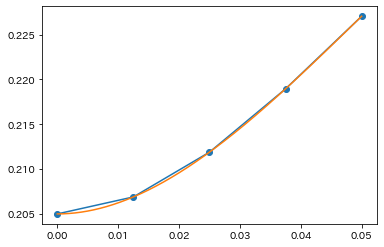

In [ ]:
#5番
#膨張部をn本で近似して壁角度を求める


#n本で区切ったらn+1この領域
x = np.linspace(0, xa, n)
x_smooth=np.linspace(0, xa, 10000)
#ノズル形状の図示
y_nozzle = throat(y0, xa, theta_max, x)
y_nozzle_smooth = throat(y0, xa, theta_max, x_smooth)

plt.plot(x, y_nozzle, '-o')
plt.plot(x_smooth, y_nozzle_smooth)
plt.show()



theta_area = [["nan" for j in range(n+2)] for i in range(n+2)]
#スローとではまっすぐ
theta_area[1][1] = 0
#壁面は直線近似、壁面での領域は流れの方向も平行
#(10.24)
for i in range(2,n+1):
    theta_area[i][1] = get_theta(xl = x[i-1], xr = x[i-2])

theta_area[n+1][1] = np.deg2rad(theta_max)



#6番
#nuとthetaの内部での値を求める
#(10.24)(10.25)
nu_area =  [["nan" for j in range(n+2)] for i in range(n+2)]
for i in range(1,n+1):
    for j in range(1,i+1):
        #(10.24)
        nu_area[i][j] = theta_area[i][1] + theta_area[j][1]
        theta_area[i][j] = theta_area[i][1] - theta_area[j][1]






#7番
#相殺部の設計
#図10.3より
#n+1分割したとして求めた角度
nu_area[n+1][1] = theta_area[n+1][1] + theta_area[1][1]



#教科書の番号のつけ方間違っている


for j in range(2, n+2):
    #(10.24)(10.25)
    nu_area[n+1][j] = theta_area[n+1][1] + theta_area[j][1]
    theta_area[n+1][j] = theta_area[n+1][1] - theta_area[j][1]
    
    #(10.3)(10.4)
    #j=nまで子か計算できない
    #nu_area[n+1][j] = (nu_area[n+1][j-1] + nu_area[n][j] + theta_area[n+1][j-1] - theta_area[n][j])/2
    #theta_area[n+1][j] = (nu_area[n+1][j-1] - nu_area[n][j] + theta_area[n+1][j-1] + theta_area[n][j])/2




交点について求めていく

In [ ]:

#8番
#交点を求めていく

#角度を求めるのに必要な状態を求める
M_area = [["nan" for j in range(n+2)] for i in range(n+2)]
#rad
beta_area = [["nan" for j in range(n+2)] for i in range(n+2)]


#p115,p178,180
#イクスパンションファン近似の二等分時にわざわざc_は求めなくてもよい。図10.3に従えばよし

for i in range(1,n+2):
    for j in range(1,i+1):
        #p115
        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html
        M_area[i][j] = optimize.bisect(get_M_from_nu, 1, 50, args=(nu_area[i][j]))
        #p180
        beta_area[i][j] = np.arcsin(1/M_area[i][j])





#p185に倣って番号をつける
#lineについてはrad、交点(i,j)に向かう線を[i][j]とした。        
       
expi_line_rad= [["nan" for j in range(n+2)] for i in range(n+2)]
expr_line_rad= [["nan" for j in range(n+2)] for i in range(n+2)]
cross_point_x= [["nan" for j in range(n+2)] for i in range(n+2)]
cross_point_y= [["nan" for j in range(n+2)] for i in range(n+2)]


for i in range(1,n+1):
    for j in range(1,i+1):
        expi_line_rad[i][j] = (theta_area[i][j] + theta_area[i+1][j] -beta_area[i][j] -beta_area[i+1][j])/2
        
for i in range(2,n+2):
    for j in range(1,i):
        expr_line_rad[i][j] = (theta_area[i][j] + theta_area[i][j+1] + beta_area[i][j] + beta_area[i][j+1])/2



for i in range(1,n+1):
    #壁側の座標
    cross_point_x[i][0]= x[i-1]
    cross_point_y[i][0]= throat(y0, xa, theta_max, cross_point_x[i][0])
    #中心の座標
    cross_point_y[i][i] = 0

for i in range(1,n+1):
    for j in range(1,i+1):
        if i == j:
            cross_point_x[i][j] = cross_point_x[i][j-1] - cross_point_y[i][j-1]/np.tan(expi_line_rad[i][j])
        else:
            numerator = cross_point_y[i][j-1] - cross_point_y[i-1][j] - cross_point_x[i][j-1]*np.tan(expi_line_rad[i][j]) + cross_point_x[i-1][j]*np.tan(expr_line_rad[i][j])
            denominator = np.tan(expr_line_rad[i][j]) - np.tan(expi_line_rad[i][j])
            cross_point_x[i][j] = numerator/denominator
            cross_point_y[i][j] = cross_point_y[i][j-1] + (cross_point_x[i][j]-cross_point_x[i][j-1])*np.tan(expi_line_rad[i][j])
            





cross_point_x[n+1][0] = xa
ya = throat(y0, xa, theta_max, xa)
cross_point_y[n+1][0] = ya

for j in range(1,n+1):
    numerator = cross_point_y[n+1][j-1] - cross_point_y[n][j] - cross_point_x[n+1][j-1]*np.tan(theta_area[n+1][j]) + cross_point_x[n][j]*np.tan(expr_line_rad[n+1][j])
    denominator = np.tan(expr_line_rad[n+1][j]) - np.tan(theta_area[n+1][j])
    cross_point_x[n+1][j] = numerator/denominator
    cross_point_y[n+1][j] = cross_point_y[n+1][j-1] + (cross_point_x[n+1][j]-cross_point_x[n+1][j-1])*np.tan(theta_area[n+1][j])



print("出口高さについて")
print("断面積から求めた結果: " + str(ye))
print("離散的に求めた結果:   " + str(cross_point_y[n+1][n]))


出口高さについて
断面積から求めた結果: 1.5881396118946747
離散的に求めた結果:   1.5405473746394187


図示する準備

In [ ]:


#交点が全部わかったので図示してみる

#expanshon fanのi番目の点を保存
ex_line = [[] for j in range(n+1)]
#無理やりそれぞれのラインの要素を追加

for i in range(1,n+1):
    for j in range(0,i+1):
        if cross_point_x[i][j] != "nan":
            ex_line[i].append([cross_point_x[i][j], cross_point_y[i][j]]) 

for i in range(1,n+1):
    for j in range(1,n+2):
        if cross_point_x[j][i] != "nan":
            ex_line[i].append([cross_point_x[j][i], cross_point_y[j][i]]) 
     
        
inner_expansion_fan = pd.DataFrame([0], columns=["x"]) 
for i in range(1,n+1):  
    label = "ex" + str(i)
    each_expansion_fan = pd.DataFrame(ex_line[i], columns=["x", label])
    inner_expansion_fan = inner_expansion_fan.append(each_expansion_fan)





#壁について


#スロート以前
x_wall_minus = np.linspace(xi, 0, 100)
y_wall_minus = throat(y0, xa, theta_max, x_wall_minus)

wall = []
for i,j in zip(x_wall_minus, y_wall_minus):
    wall.append([i,j])



for i in range(1,n+1):
        if cross_point_x[i][0] != "nan":
            wall.append([cross_point_x[i][0], cross_point_y[i][0]]) 
            
for i in range(1,n+1):
        if cross_point_x[n+1][i] != "nan":
            wall.append([cross_point_x[n+1][i], cross_point_y[n+1][i]])        

inner_expansion_fan = inner_expansion_fan.append(pd.DataFrame(wall, columns=["x", "wall"]))
 




#中心軸について
xe = cross_point_x[n+1][n]
print("出口の位置: " + str(xe))


central_axis = []
central_axis.append([xi,0])
central_axis.append([xe,0])



inner_expansion_fan = inner_expansion_fan.append(pd.DataFrame(central_axis, columns=["x", "central_axis"]))


出口の位置: 6.015926616918701


ノズルの図示

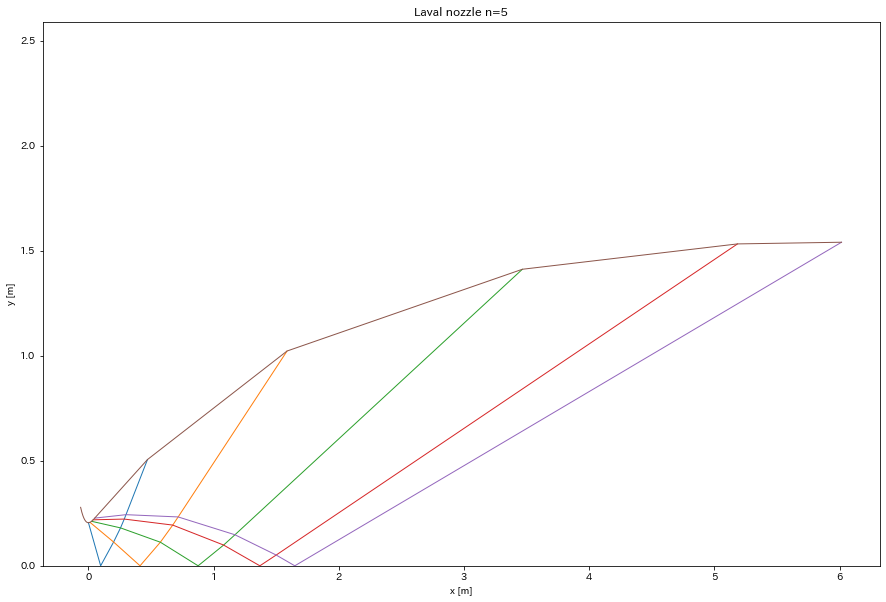

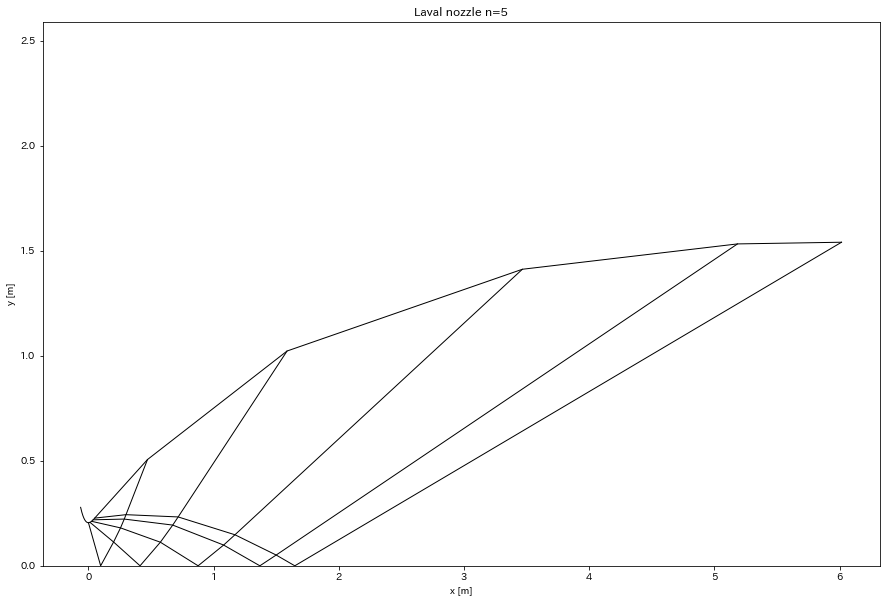

In [ ]:

#inner_expansion_fan.plot(x="x")      
#inner_expansion_fan.plot(x="x", legend = False,ylim=[0,abs(ye)+1])    

#img = inner_expansion_fan.plot(x="x", ylim=[0,6], figsize=(15, 10), legend = False,  xlabel="x [m]", ylabel="y [m]", title="Laval nozzle n={}".format(n),lw=1,style='o-').get_figure() 
img = inner_expansion_fan.plot(x="x", ylim=[0,abs(ye)+1], figsize=(15, 10), legend = False,  xlabel="x [m]", ylabel="y [m]", title="Laval nozzle n={}".format(n),lw=1).get_figure()         
img = inner_expansion_fan.plot(x="x", ylim=[0,abs(ye)+1], figsize=(15, 10), legend = False,  xlabel="x [m]", ylabel="y [m]", title="Laval nozzle n={}".format(n),lw=1, color ="k").get_figure()   



線ありでマッハ数を色付け

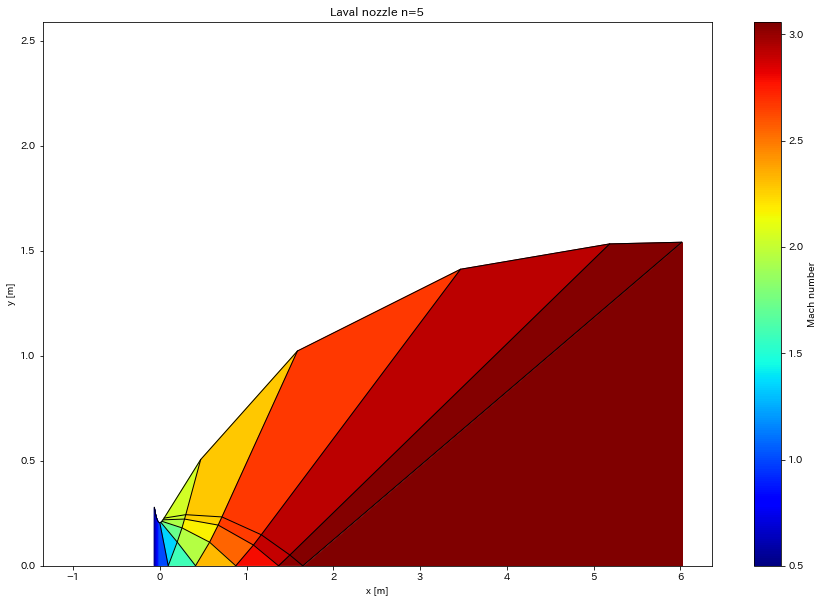

In [ ]:

color_Mmax = Me
color_Mmin = Mi

#マッハ数を塗ってみる
#ここを引きずってしまっている
img = inner_expansion_fan.plot(x="x", ylim=[0,abs(ye)+1], figsize=(15, 10), legend = False,  xlabel="x [m]", ylabel="y [m]", title="Laval nozzle n={}".format(n),lw=1, color ="k").get_figure()   


import matplotlib.cm as cm
#マッハ数変化
#https://cranethree.hatenablog.com/entry/2015/07/25/204608
#https://qiita.com/hokekiyoo/items/cea310b2c36a01b970a6




#スロ―ト以前
for i in range(len(x_wall_minus)-1):
       
    testx = [x_wall_minus[i], x_wall_minus[i+1], x_wall_minus[i+1], x_wall_minus[i]]
    testy = [0, 0, y_wall_minus[i+1], y_wall_minus[i]]
    MM = optimize.bisect(getM_from_y, 0.1, 0.999, args=(y_wall_minus[i]))
    plt.fill(testx,testy,color=cm.jet((MM-color_Mmin)/(color_Mmax-color_Mmin)))



#四角形
for i in range(2,n+2):
    for j in range(1,i):

        testx = [cross_point_x[i-1][j-1], cross_point_x[i-1][j], cross_point_x[i][j], cross_point_x[i][j-1]]
        testy = [cross_point_y[i-1][j-1], cross_point_y[i-1][j], cross_point_y[i][j], cross_point_y[i][j-1]]
        #plt.fill(testx,testy,color="y",alpha=(M_area[i][j]-1)/(Me-Mi))
        plt.fill(testx,testy,color=cm.jet((M_area[i][j]-color_Mmin)/(color_Mmax-color_Mmin)))
      
#三角形 
for i in range(2,n+1): 
        testx = [cross_point_x[i-1][i-1], cross_point_x[i][i], cross_point_x[i][i-1]]
        testy = [cross_point_y[i-1][i-1], cross_point_y[i][i], cross_point_y[i][i-1]]
        plt.fill(testx,testy,color=cm.jet((M_area[i][i]-color_Mmin)/(color_Mmax-color_Mmin)))

#(1,1)
testx = [0, cross_point_x[1][1], cross_point_x[1][0]]
testy = [0, cross_point_y[1][1], cross_point_y[1][0]]
plt.fill(testx,testy,color=cm.jet((M_area[1][1]-color_Mmin)/(color_Mmax-color_Mmin)))

#(n+1,n+1)
testx = [cross_point_x[n][n], cross_point_x[n+1][n], cross_point_x[n+1][n]]
testy = [cross_point_y[n][n], 0, cross_point_y[n+1][n]]
plt.fill(testx,testy,color=cm.jet((M_area[n+1][n+1]-color_Mmin)/(color_Mmax-color_Mmin)))




#カラーバーを無理やり表示外にかく
a=np.linspace(-1,-1,100)
b=np.linspace(-1,-1,100)
c=np.linspace(color_Mmin,color_Mmax,100).reshape(10,10)


sc = plt.scatter(a,b,c=c,cmap=plt.cm.jet,alpha=1)
plt.colorbar(sc,label="Mach number")
plt.show()

線なしでマッハ数色付け

In [ ]:

color_Mmax = Me
color_Mmin = Mi

#color_Mmax = 4
#color_Mmin = 0



#横に二つ並べてみる

#https://www.delftstack.com/ja/howto/matplotlib/how-to-make-different-subplot-sizes-in-matplotlib/
from matplotlib import gridspec

fig = plt.figure(figsize=(15, 10),dpi = 1000)
#fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[50, 1])


ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])



import matplotlib.cm as cm
#マッハ数変化
#https://cranethree.hatenablog.com/entry/2015/07/25/204608
#https://qiita.com/hokekiyoo/items/cea310b2c36a01b970a6


#スロ―ト以前
for i in range(len(x_wall_minus)-1):
       
    testx = [x_wall_minus[i], x_wall_minus[i+1], x_wall_minus[i+1], x_wall_minus[i]]
    testy = [0, 0, y_wall_minus[i+1], y_wall_minus[i]]
    MM = optimize.bisect(getM_from_y, 0.1, 0.999, args=(y_wall_minus[i]))
    ax1.fill(testx,testy,color=cm.jet((MM-color_Mmin)/(color_Mmax-color_Mmin)))


#四角形
for i in range(2,n+2):
    for j in range(1,i):

        testx = [cross_point_x[i-1][j-1], cross_point_x[i-1][j], cross_point_x[i][j], cross_point_x[i][j-1]]
        testy = [cross_point_y[i-1][j-1], cross_point_y[i-1][j], cross_point_y[i][j], cross_point_y[i][j-1]]
        #plt.fill(testx,testy,color="y",alpha=(M_area[i][j]-1)/(Me-Mi))
        ax1.fill(testx,testy,color=cm.jet((M_area[i][j]-color_Mmin)/(color_Mmax-color_Mmin)))
#三角形            
for i in range(2,n+1): 
        testx = [cross_point_x[i-1][i-1], cross_point_x[i][i], cross_point_x[i][i-1]]
        testy = [cross_point_y[i-1][i-1], cross_point_y[i][i], cross_point_y[i][i-1]]
        ax1.fill(testx,testy,color=cm.jet((M_area[i][i]-color_Mmin)/(color_Mmax-color_Mmin)))

#(1,1)
testx = [0, cross_point_x[1][1], cross_point_x[1][0]]
testy = [0, cross_point_y[1][1], cross_point_y[1][0]]
ax1.fill(testx,testy,color=cm.jet((M_area[1][1]-color_Mmin)/(color_Mmax-color_Mmin)))

#(n+1,n+1)
testx = [cross_point_x[n][n], cross_point_x[n+1][n], cross_point_x[n+1][n]]
testy = [cross_point_y[n][n], 0, cross_point_y[n+1][n]]
ax1.fill(testx,testy,color=cm.jet((M_area[n+1][n+1]-color_Mmin)/(color_Mmax-color_Mmin)))




#https://bourbaki.biz/matplotlib-colorbarbase-document/
#https://illumination-k.dev/posts/python/colorbar_and_normvalue
import matplotlib as mpl
vmin = Mi
vmax = Me
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cbar = mpl.colorbar.ColorbarBase(
    ax=ax2,
    cmap=plt.cm.jet,
    norm=norm,
    orientation="vertical",
    label="Mach number",
)



plt.show()



流れ方向θを矢印で示したかったが失敗

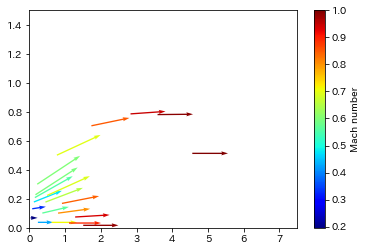

In [ ]:

#θを矢印で表示したい

#https://phst.hateblo.jp/entry/2020/12/22/000000

px=[]
py=[]
vx=[]
vy=[]
colors=[]



for i in range(2,n+2):
    for j in range(1,i):
        testx = [cross_point_x[i-1][j-1], cross_point_x[i-1][j], cross_point_x[i][j], cross_point_x[i][j-1]]
        testy = [cross_point_y[i-1][j-1], cross_point_y[i-1][j], cross_point_y[i][j], cross_point_y[i][j-1]]
        px.append(sum(testx)/len(testx))
        py.append(sum(testy)/len(testy))
        vx.append(np.cos(theta_area[i][j]) * (M_area[i][j]-Mi)/(Me-Mi))
        vy.append(np.sin(theta_area[i][j]) * (M_area[i][j]-Mi)/(Me-Mi))
        colors.append((M_area[i][j]-Mi)/(Me-Mi))



for i in range(2,n+1): 
        testx = [cross_point_x[i-1][i-1], cross_point_x[i][i], cross_point_x[i][i-1]]
        testy = [cross_point_y[i-1][i-1], cross_point_y[i][i], cross_point_y[i][i-1]]
        px.append(sum(testx)/len(testx))
        py.append(sum(testy)/len(testy))
        vx.append(np.cos(theta_area[i][i]) * (M_area[i][i]-Mi)/(Me-Mi))
        vy.append(np.sin(theta_area[i][i]) * (M_area[i][i]-Mi)/(Me-Mi))
        colors.append((M_area[i][i]-Mi)/(Me-Mi))




#(1,1)
testx = [0, cross_point_x[1][1], cross_point_x[1][0]]
testy = [0, cross_point_y[1][1], cross_point_y[1][0]]
px.append(sum(testx)/len(testx))
py.append(sum(testy)/len(testy))
vx.append(np.cos(theta_area[1][1]) * (M_area[1][1]-Mi)/(Me-Mi))
vy.append(np.sin(theta_area[1][1]) * (M_area[1][1]-Mi)/(Me-Mi))
colors.append((M_area[1][1]-Mi)/(Me-Mi))

#(n+1,n+1)
testx = [cross_point_x[n][n], cross_point_x[n+1][n], cross_point_x[n+1][n]]
testy = [cross_point_y[n][n], 0, cross_point_y[n+1][n]]
px.append(sum(testx)/len(testx))
py.append(sum(testy)/len(testy))
vx.append(np.cos(theta_area[n+1][n+1]) * (M_area[n+1][n+1]-Mi)/(Me-Mi))
vy.append(np.sin(theta_area[n+1][n+1]) * (M_area[n+1][n+1]-Mi)/(Me-Mi))
colors.append((M_area[n+1][n+1]-Mi)/(Me-Mi))



fig = plt.figure()
ax3 = fig.add_subplot(111) 
#ax.gca().set_aspect('equal')
im = ax3.quiver(px,py,vx,vy,colors, cmap=cm.jet, scale = 1,scale_units='xy',headwidth=3,width=0.005)
ax3.set_xlim(0,7.5)
ax3.set_ylim(0,1.5)
fig.colorbar(im,label="Mach number")
#im.set_clim(0,16)
plt.show()

img = inner_expansion_fan.plot(x="x",ax = ax3, ylim=[0,4], figsize=(30, 20),  legend = False,  xlabel="x [m]", ylabel="x [m]", title="Laval nozzle n={}".format(n),lw=1).get_figure()   
#img.savefig("圧縮12")
inner_expansion_fan.plot(x="x",ax = ax3, ylim=[0,6], figsize=(15, 10), legend = False,  xlabel="x [m]", ylabel="x [m]", title="Laval nozzle n={}".format(n),lw=1)
plt.show()





各種パラメータの表示

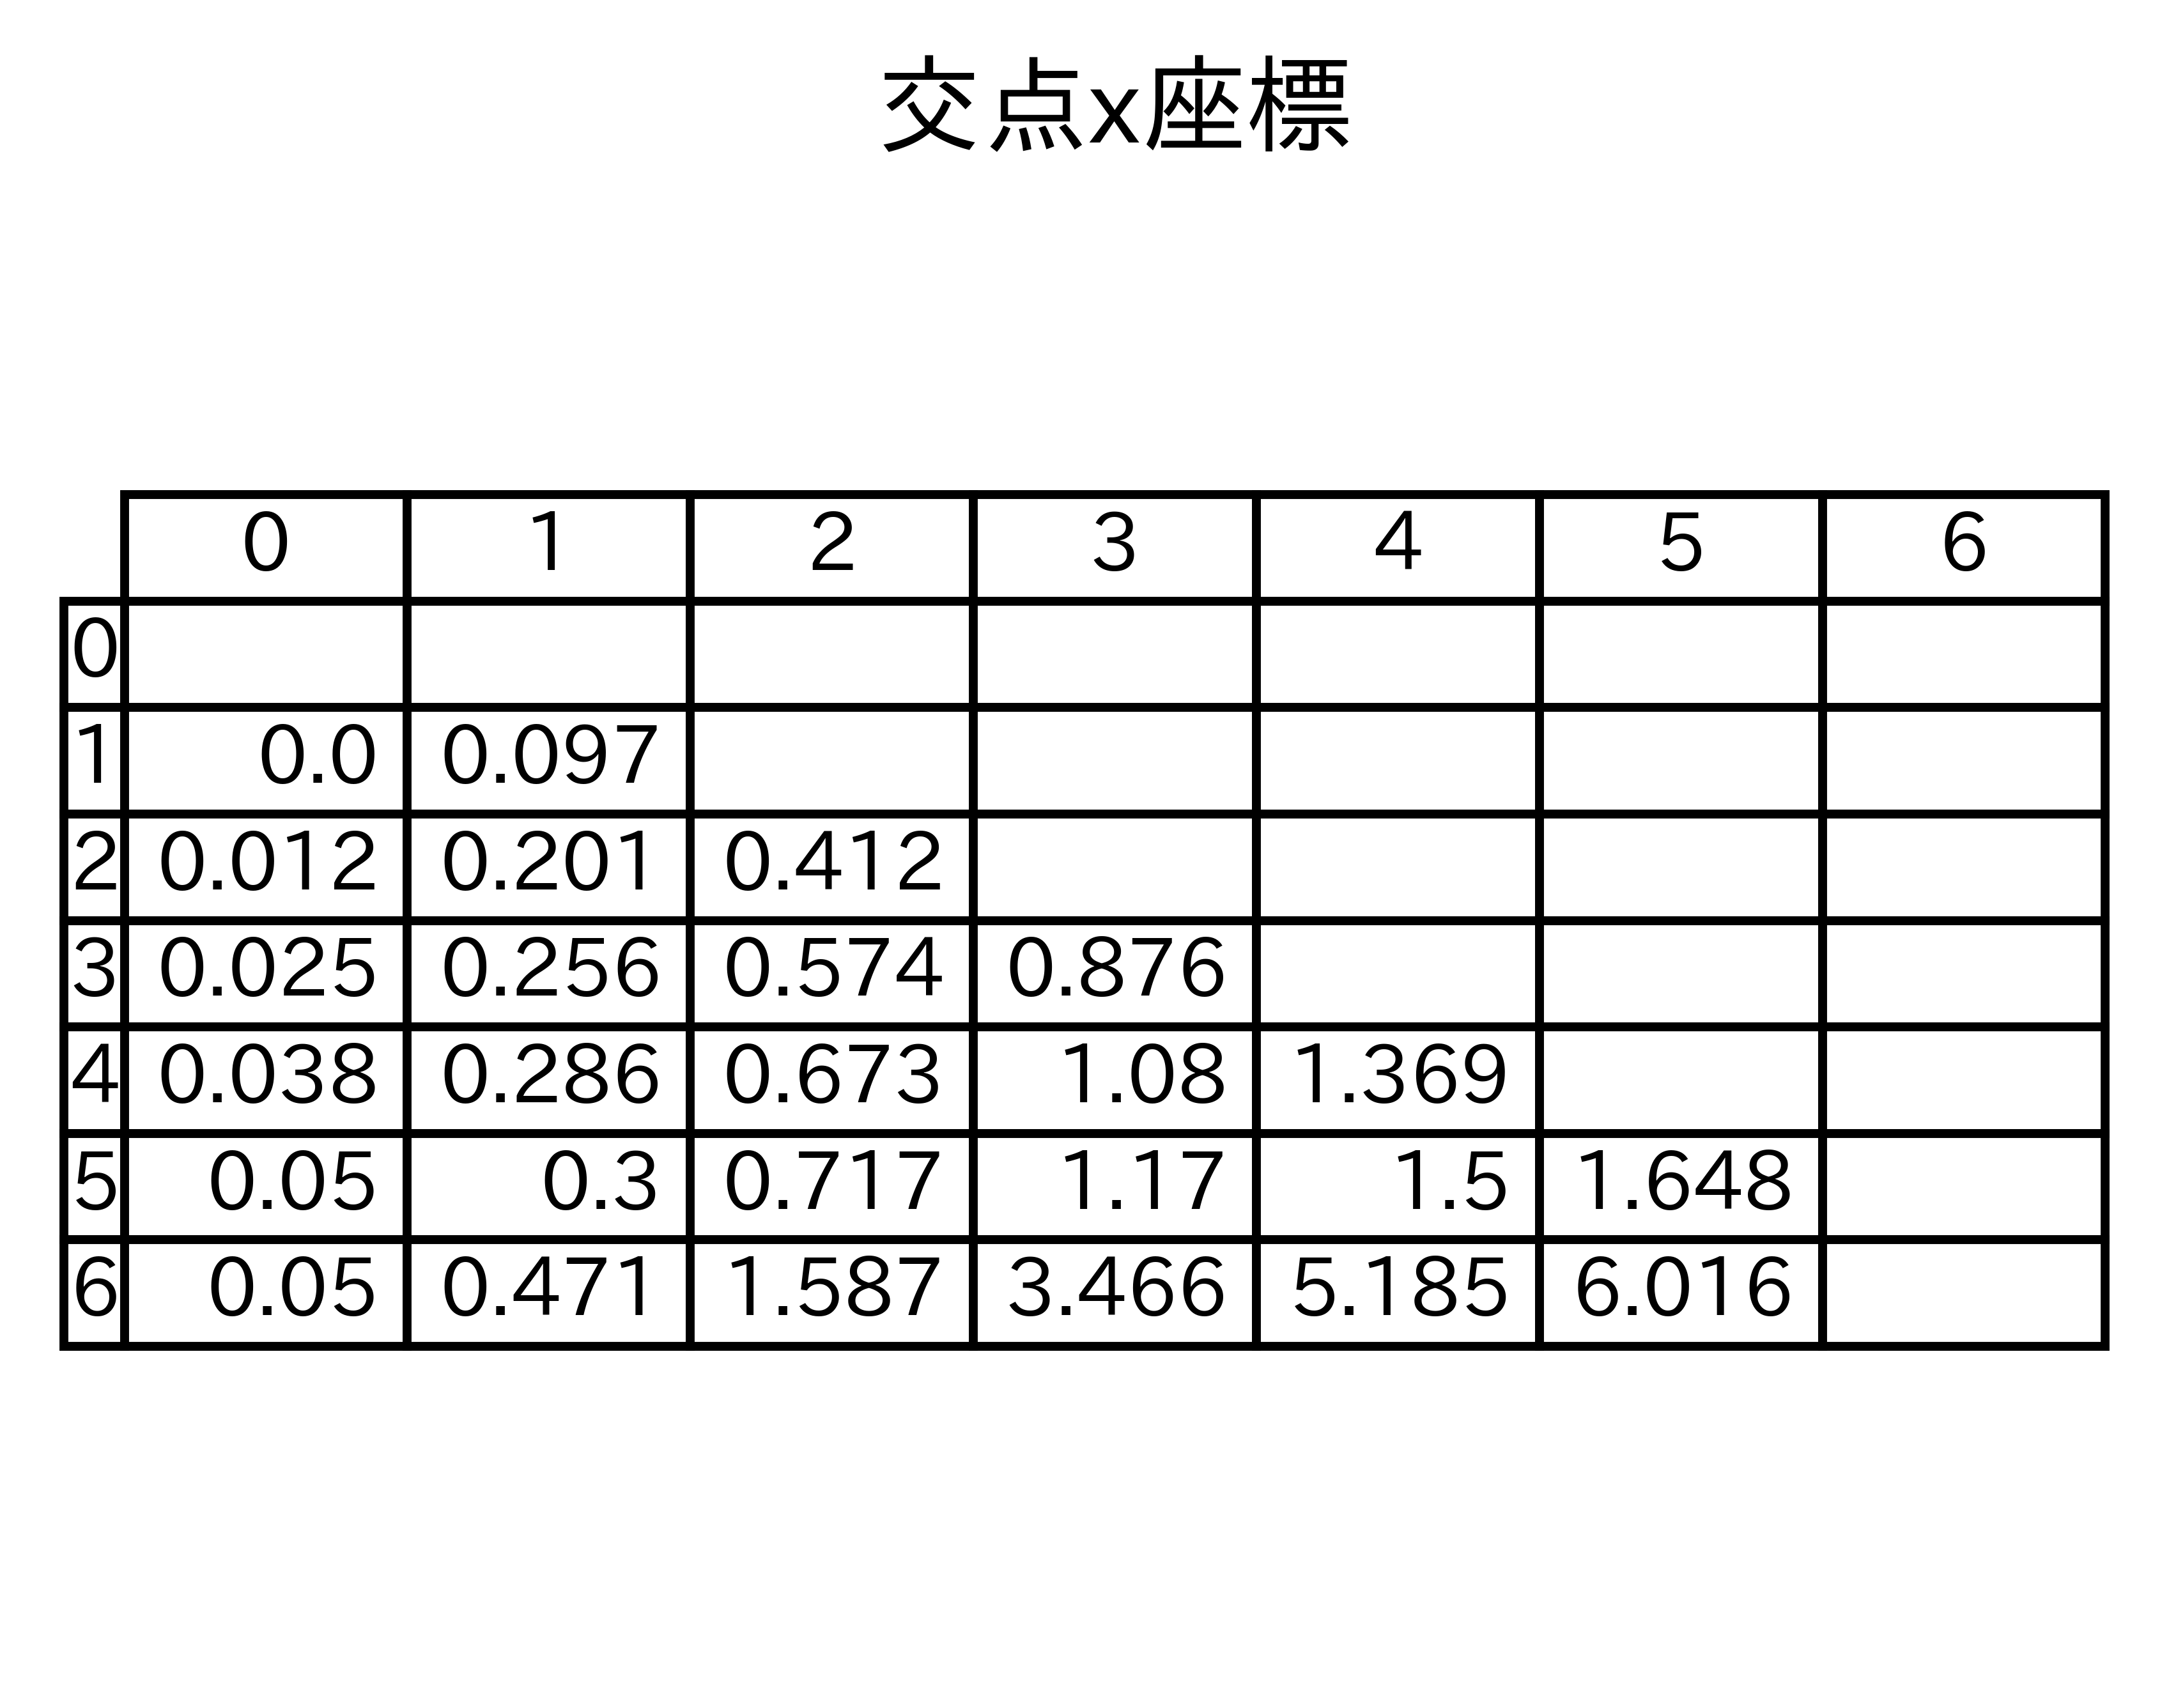

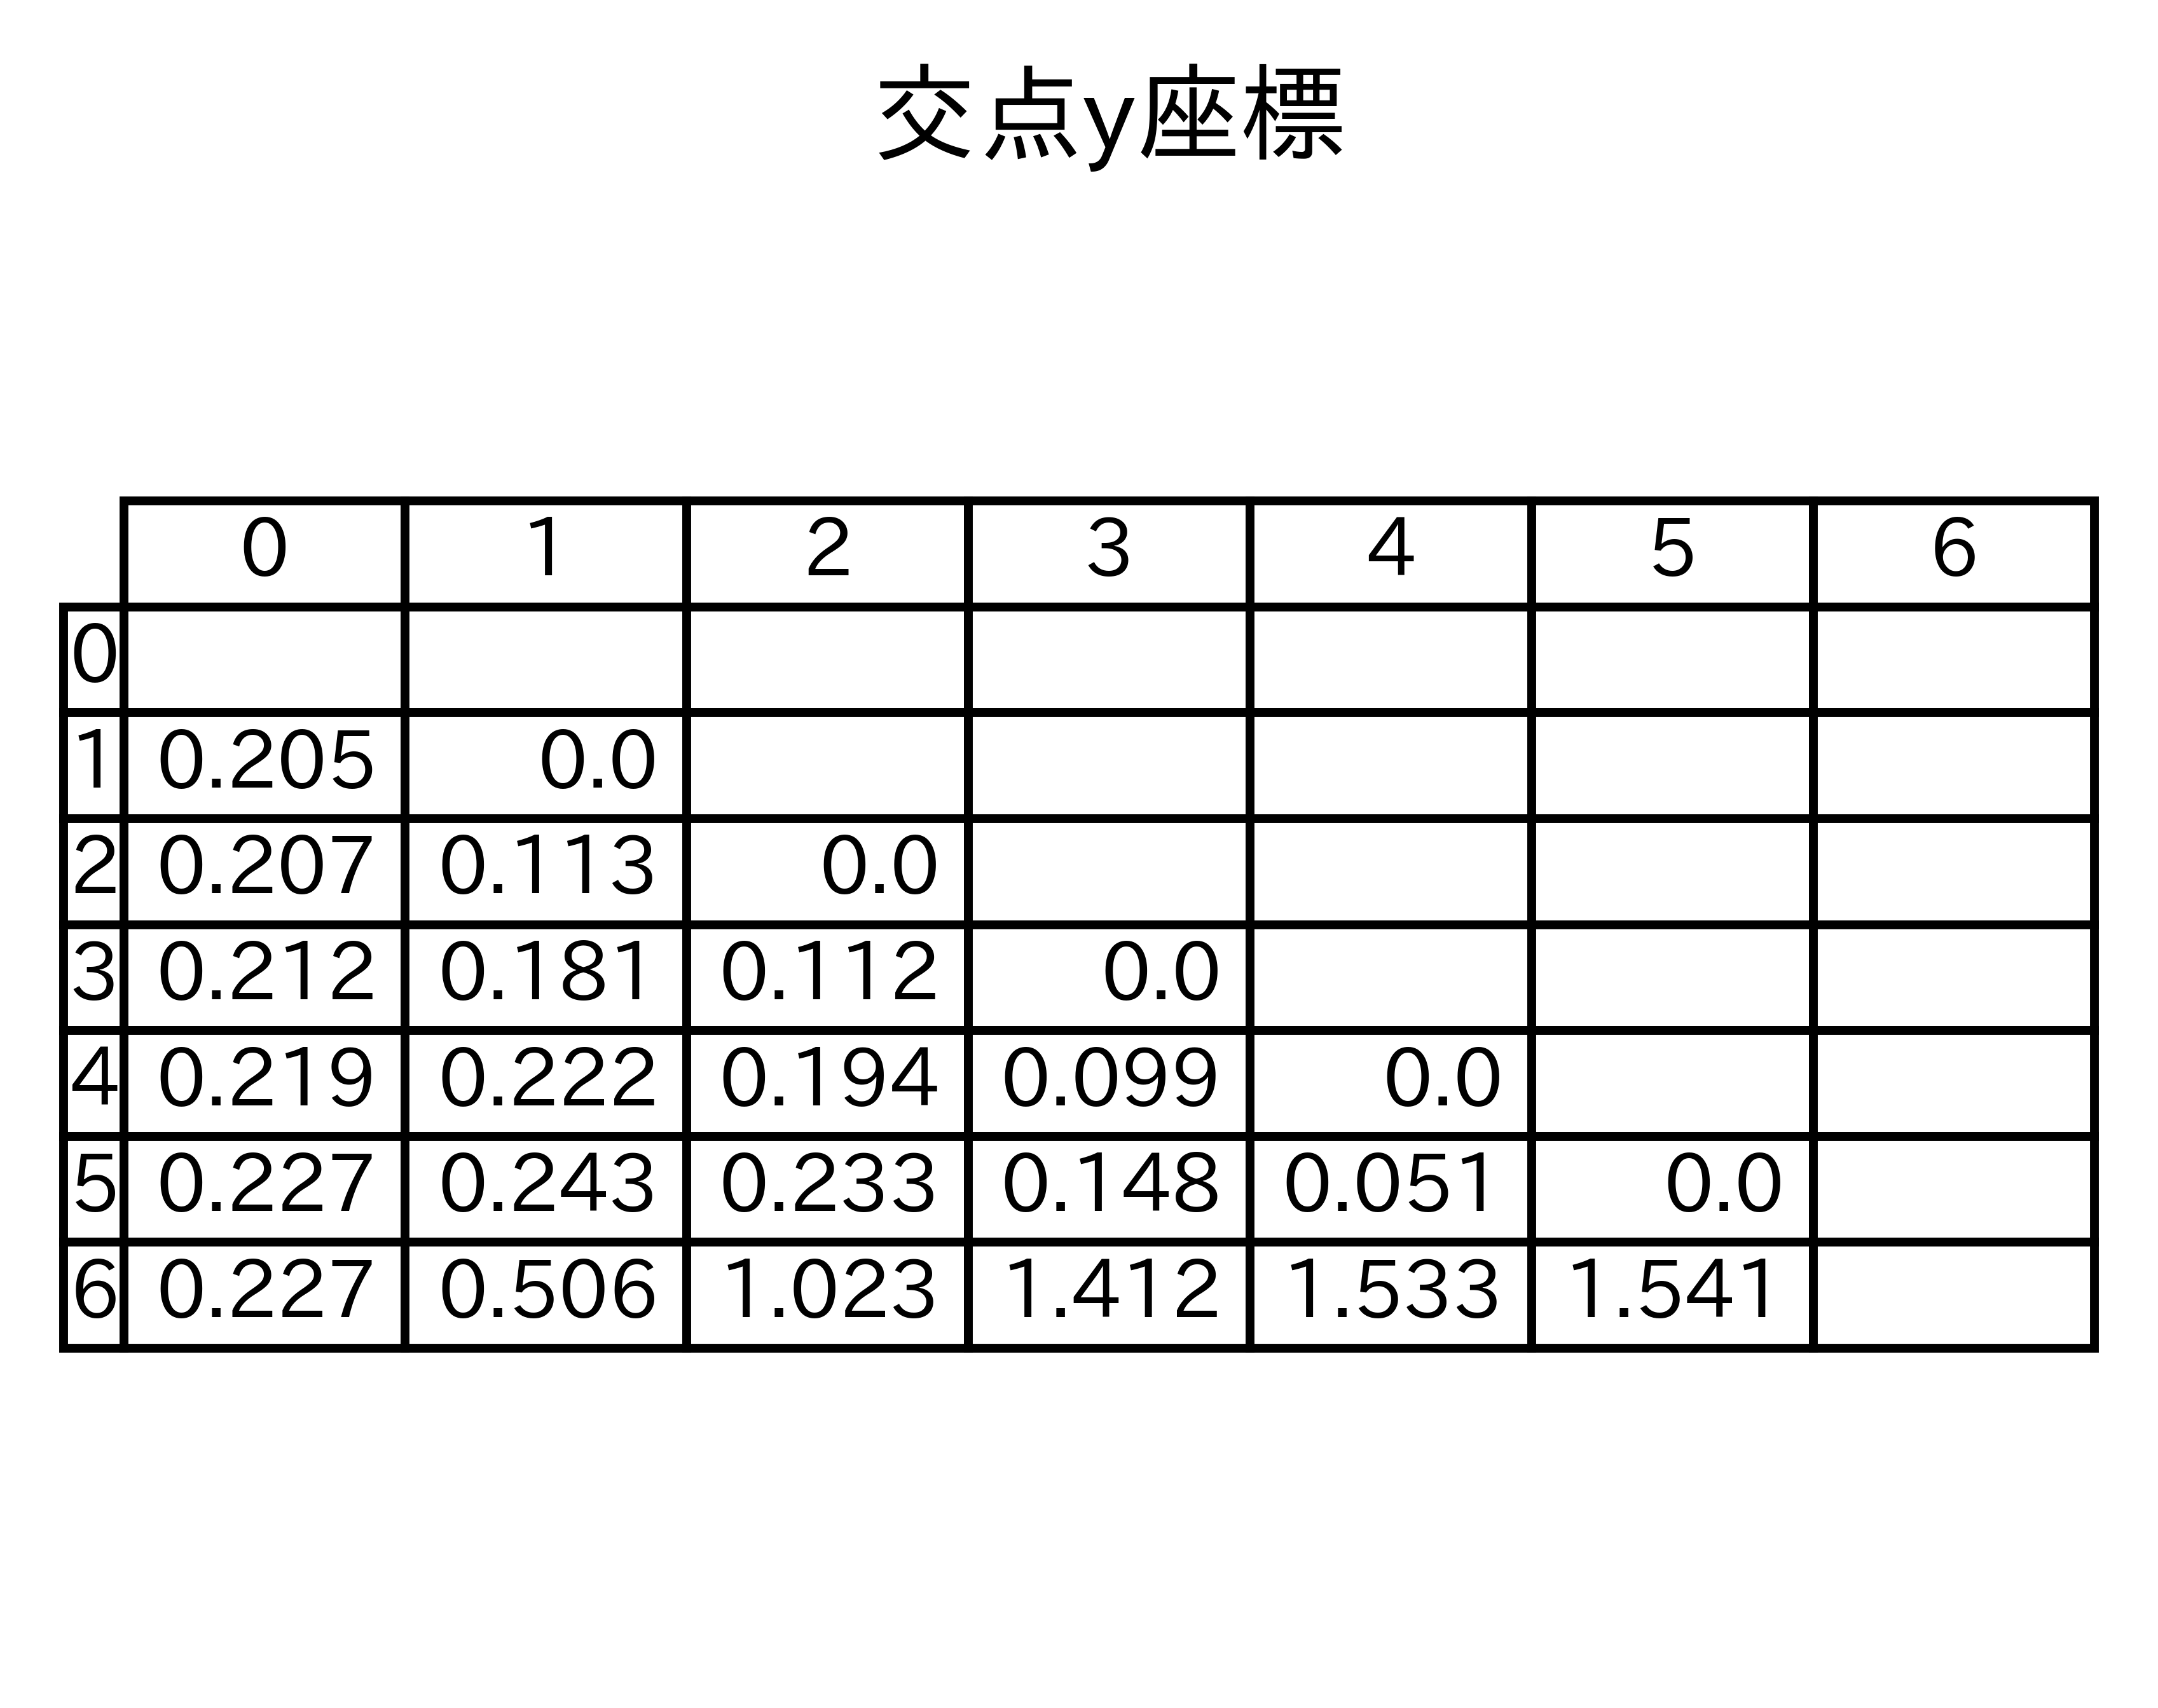

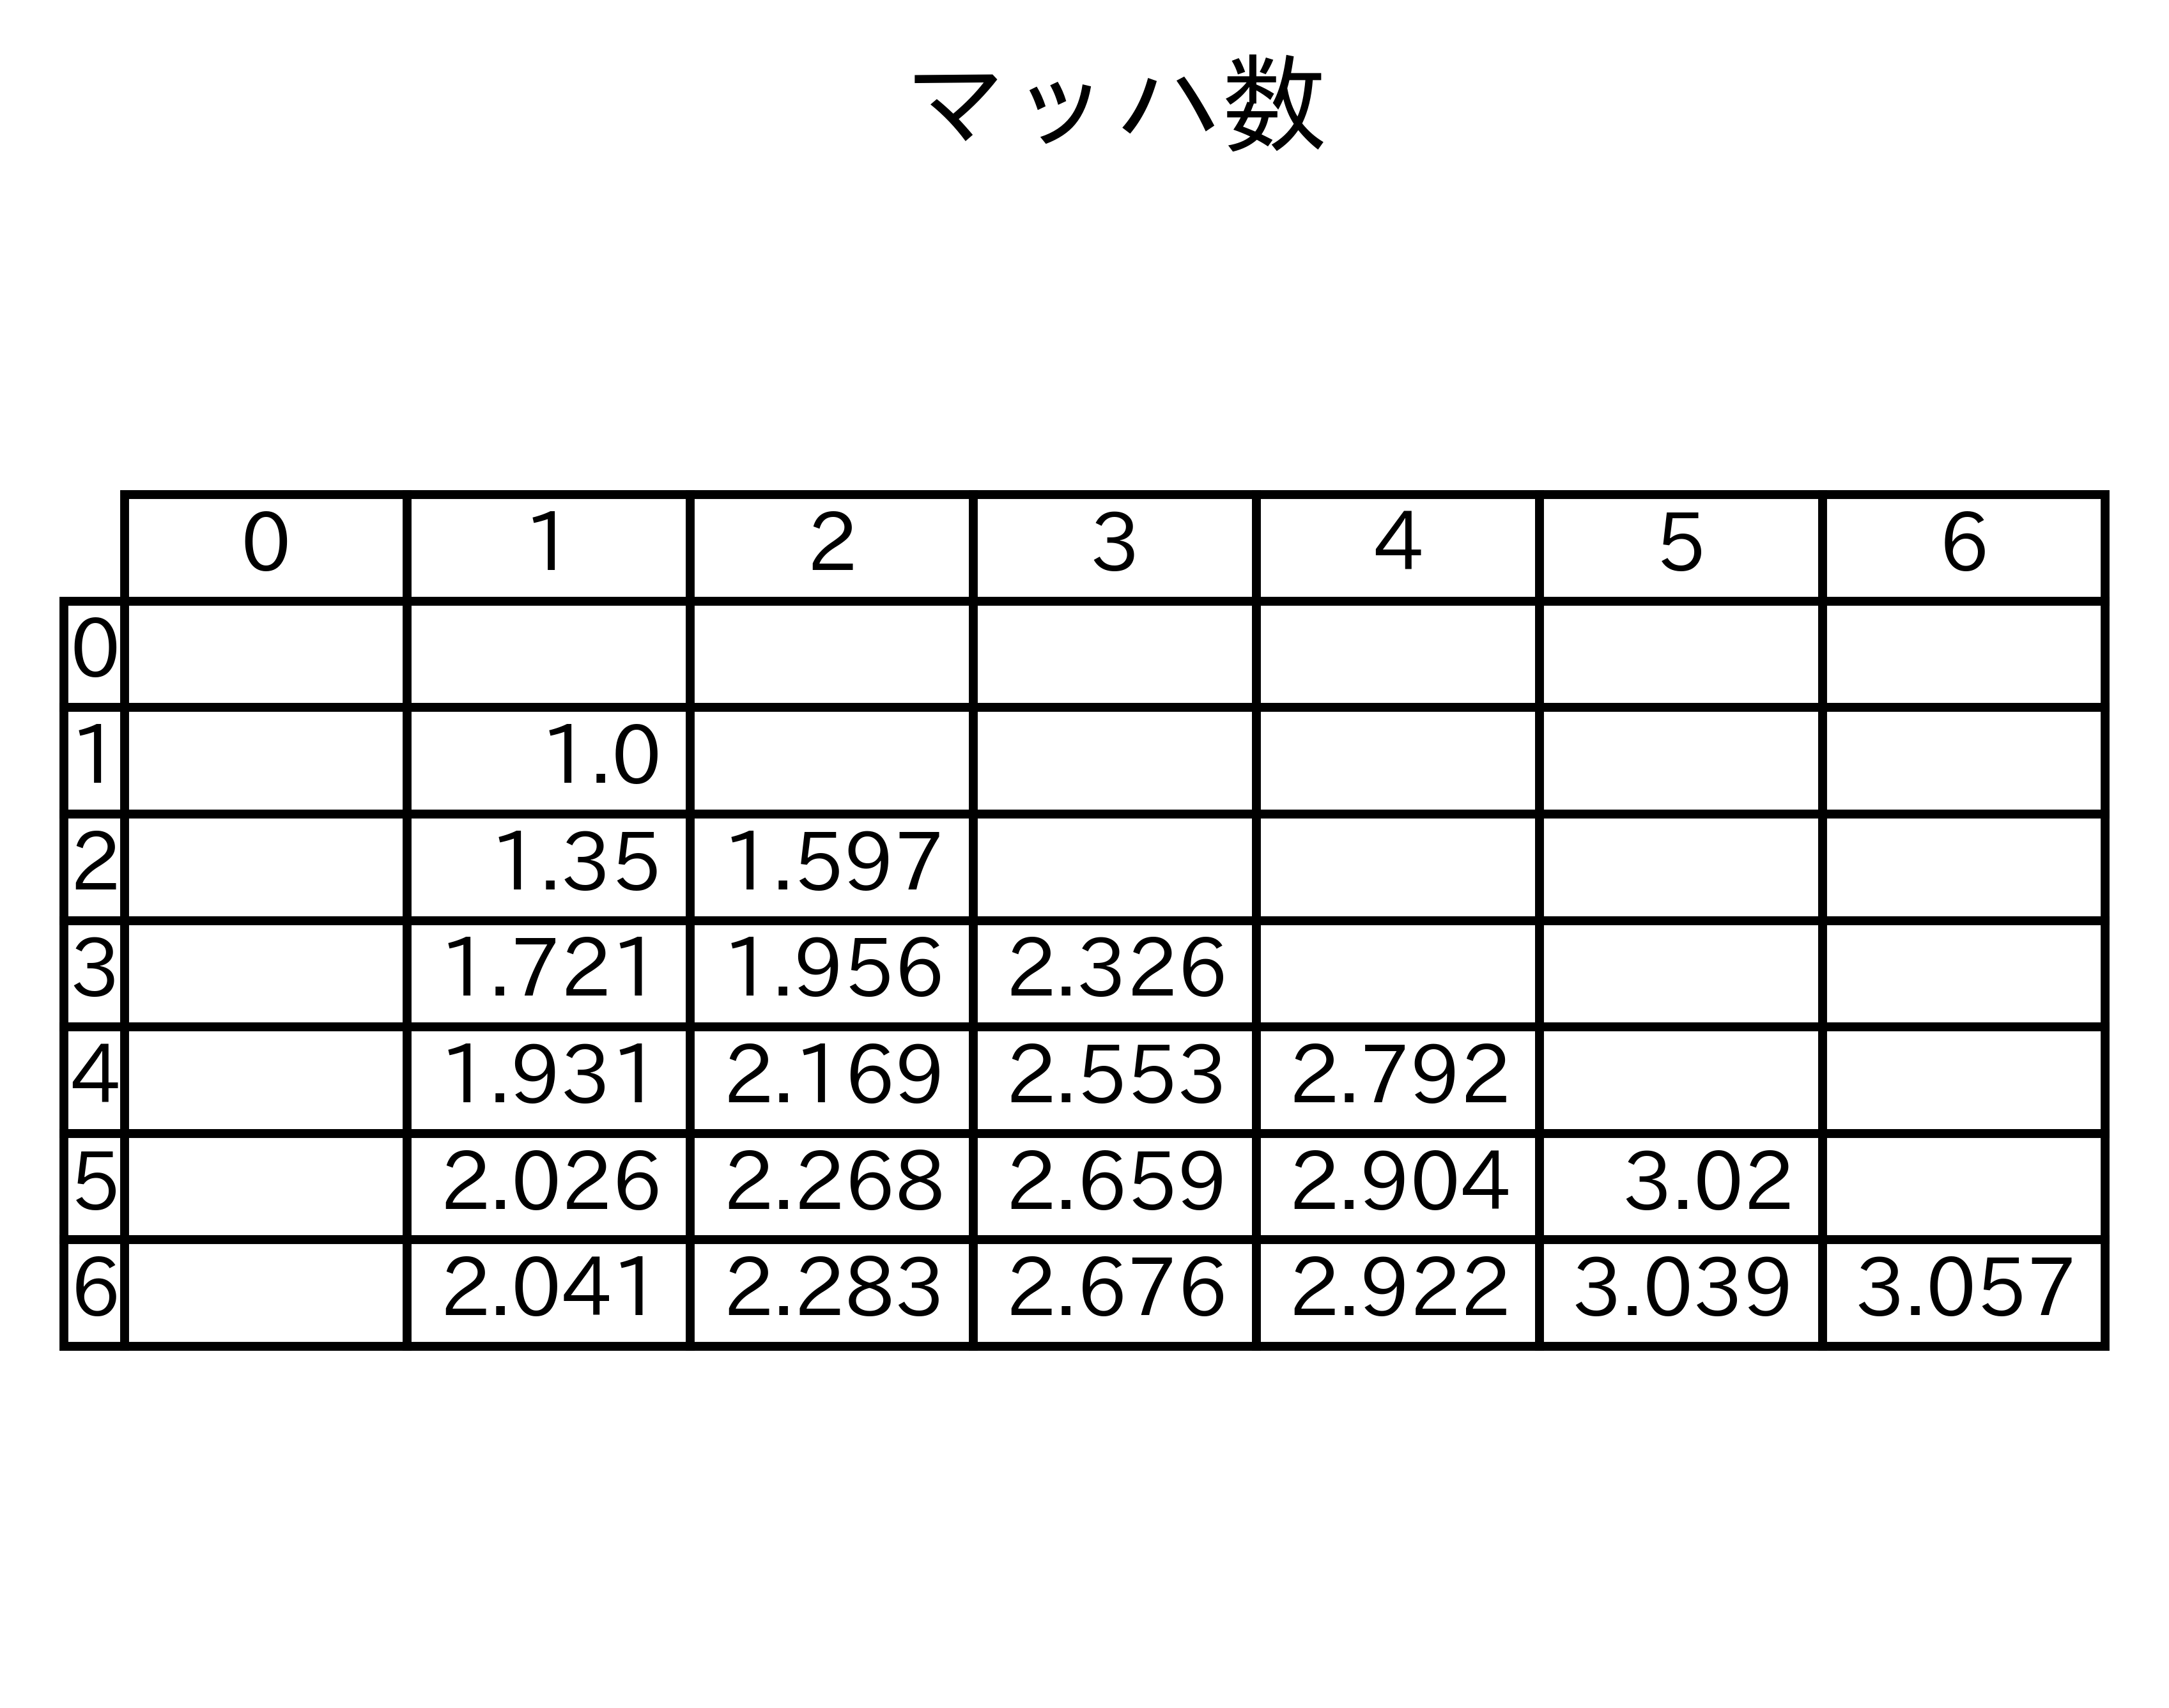

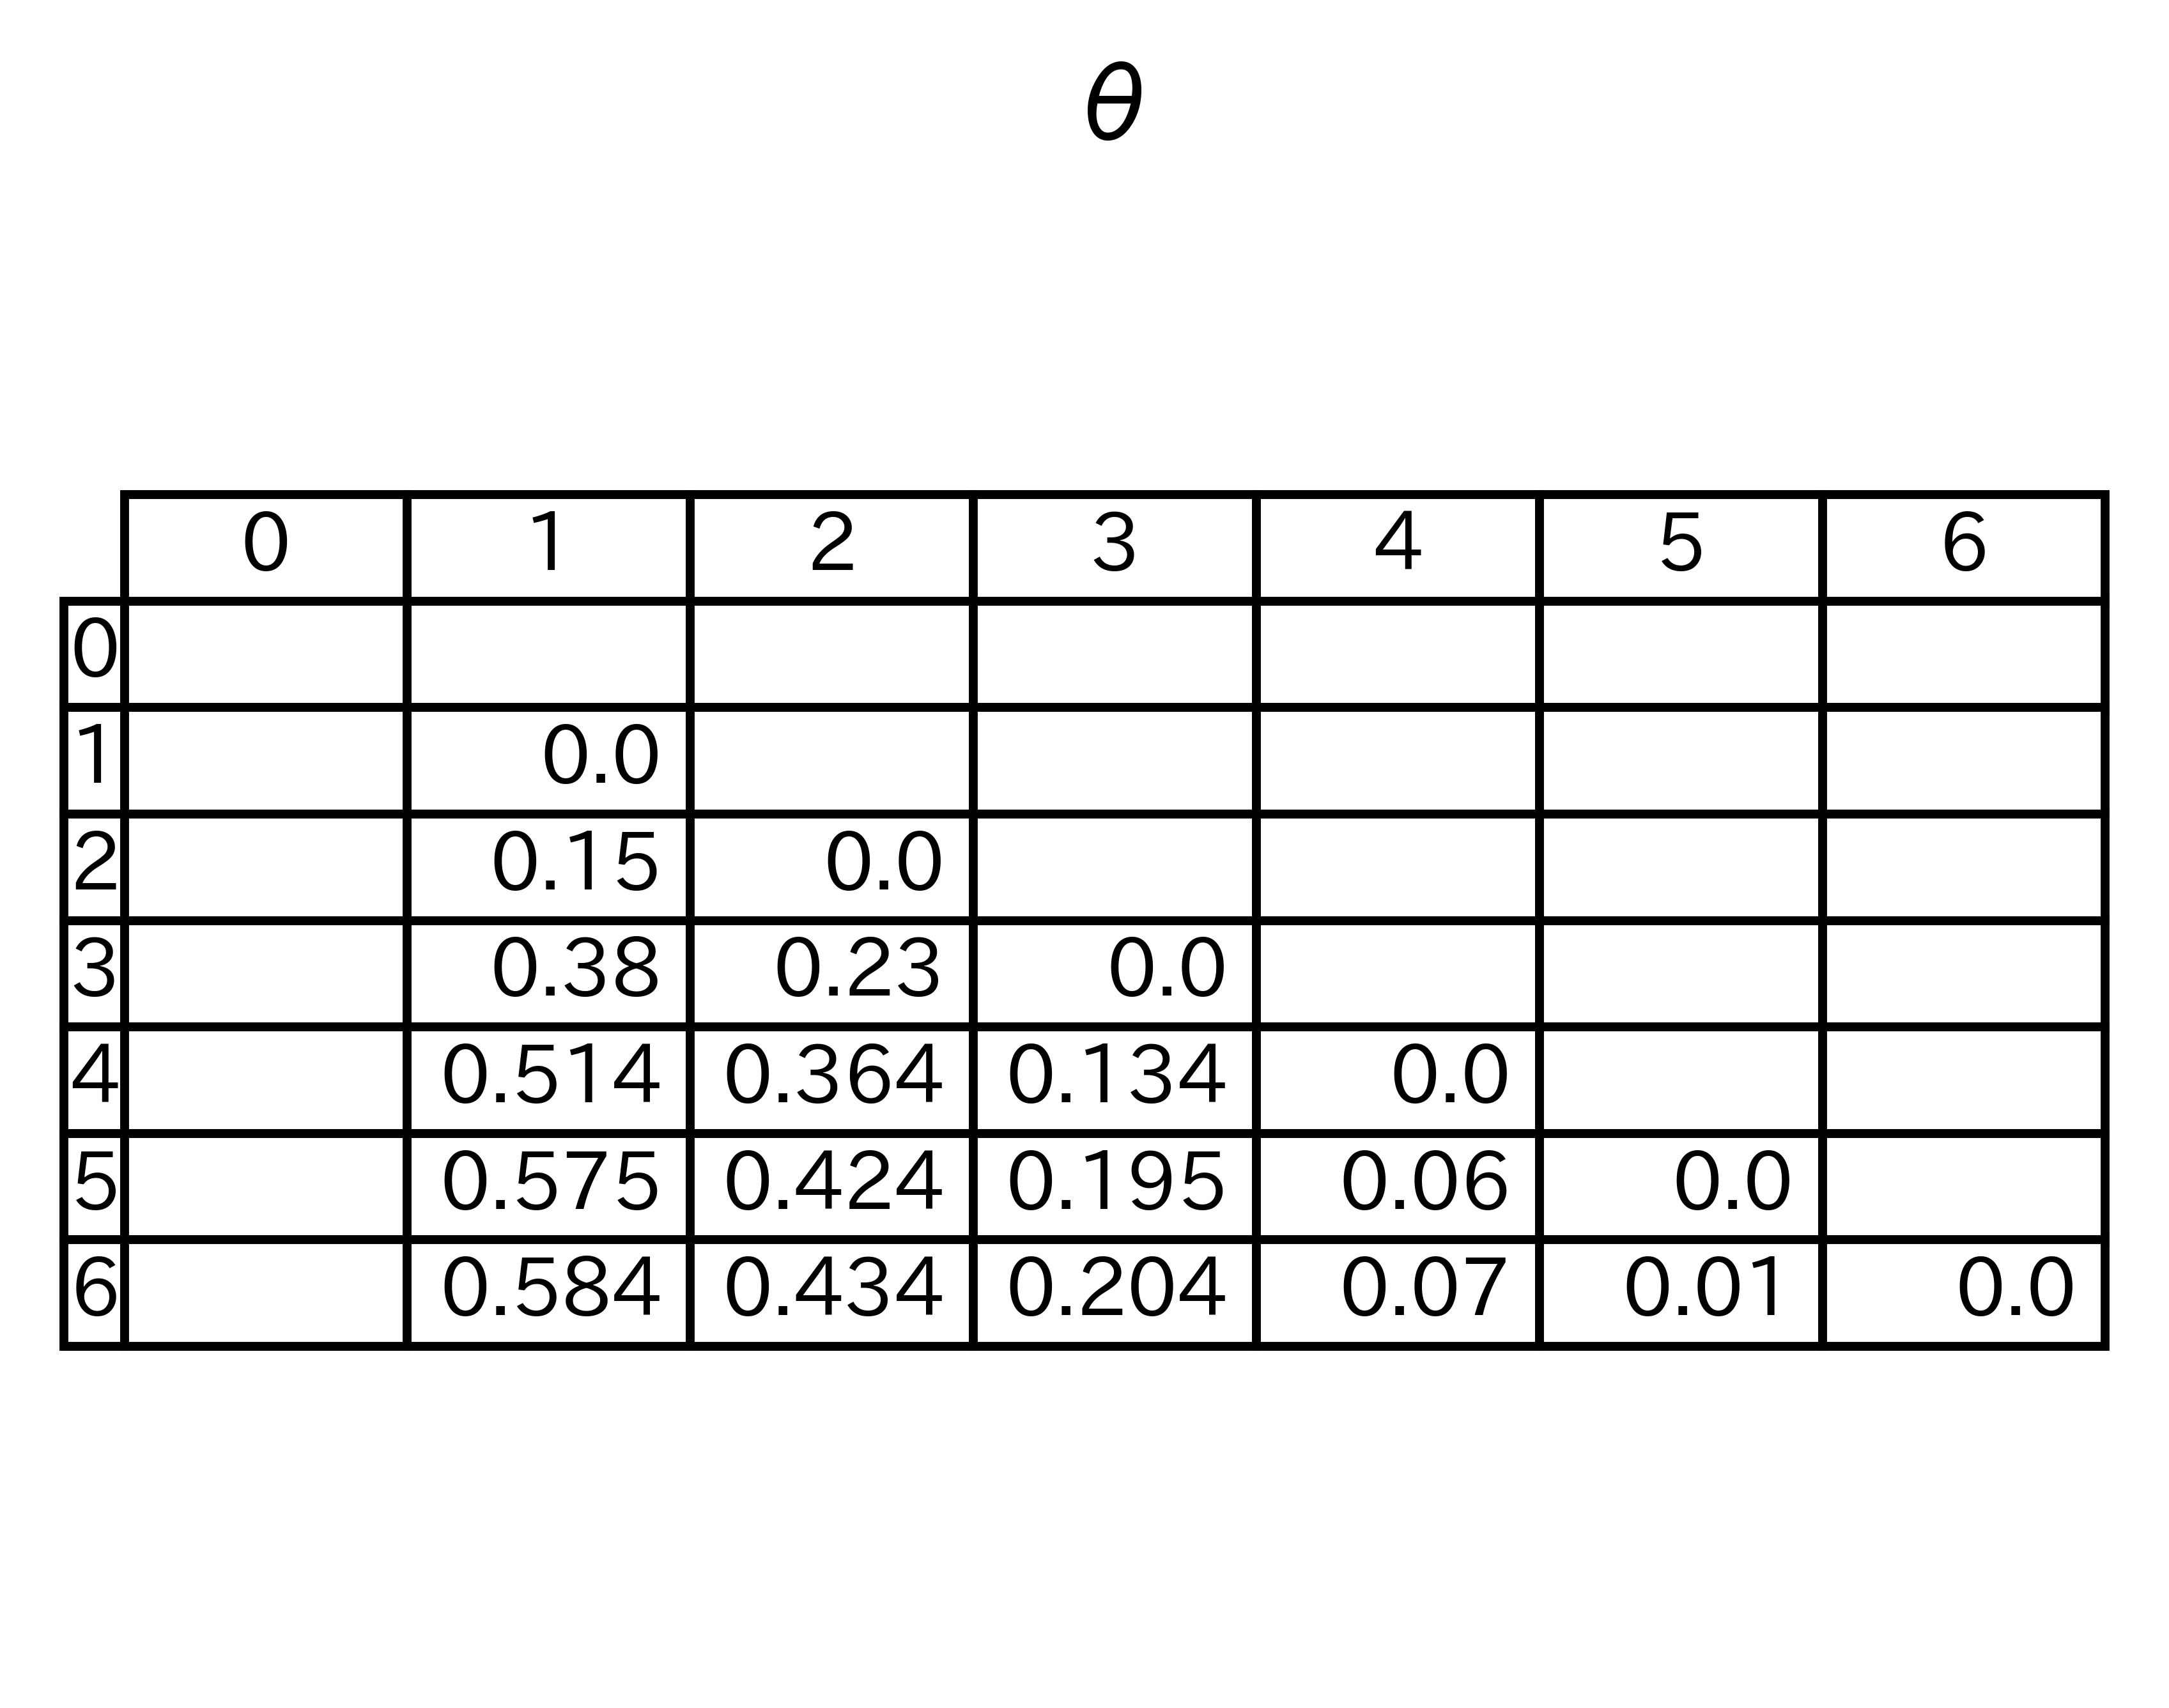

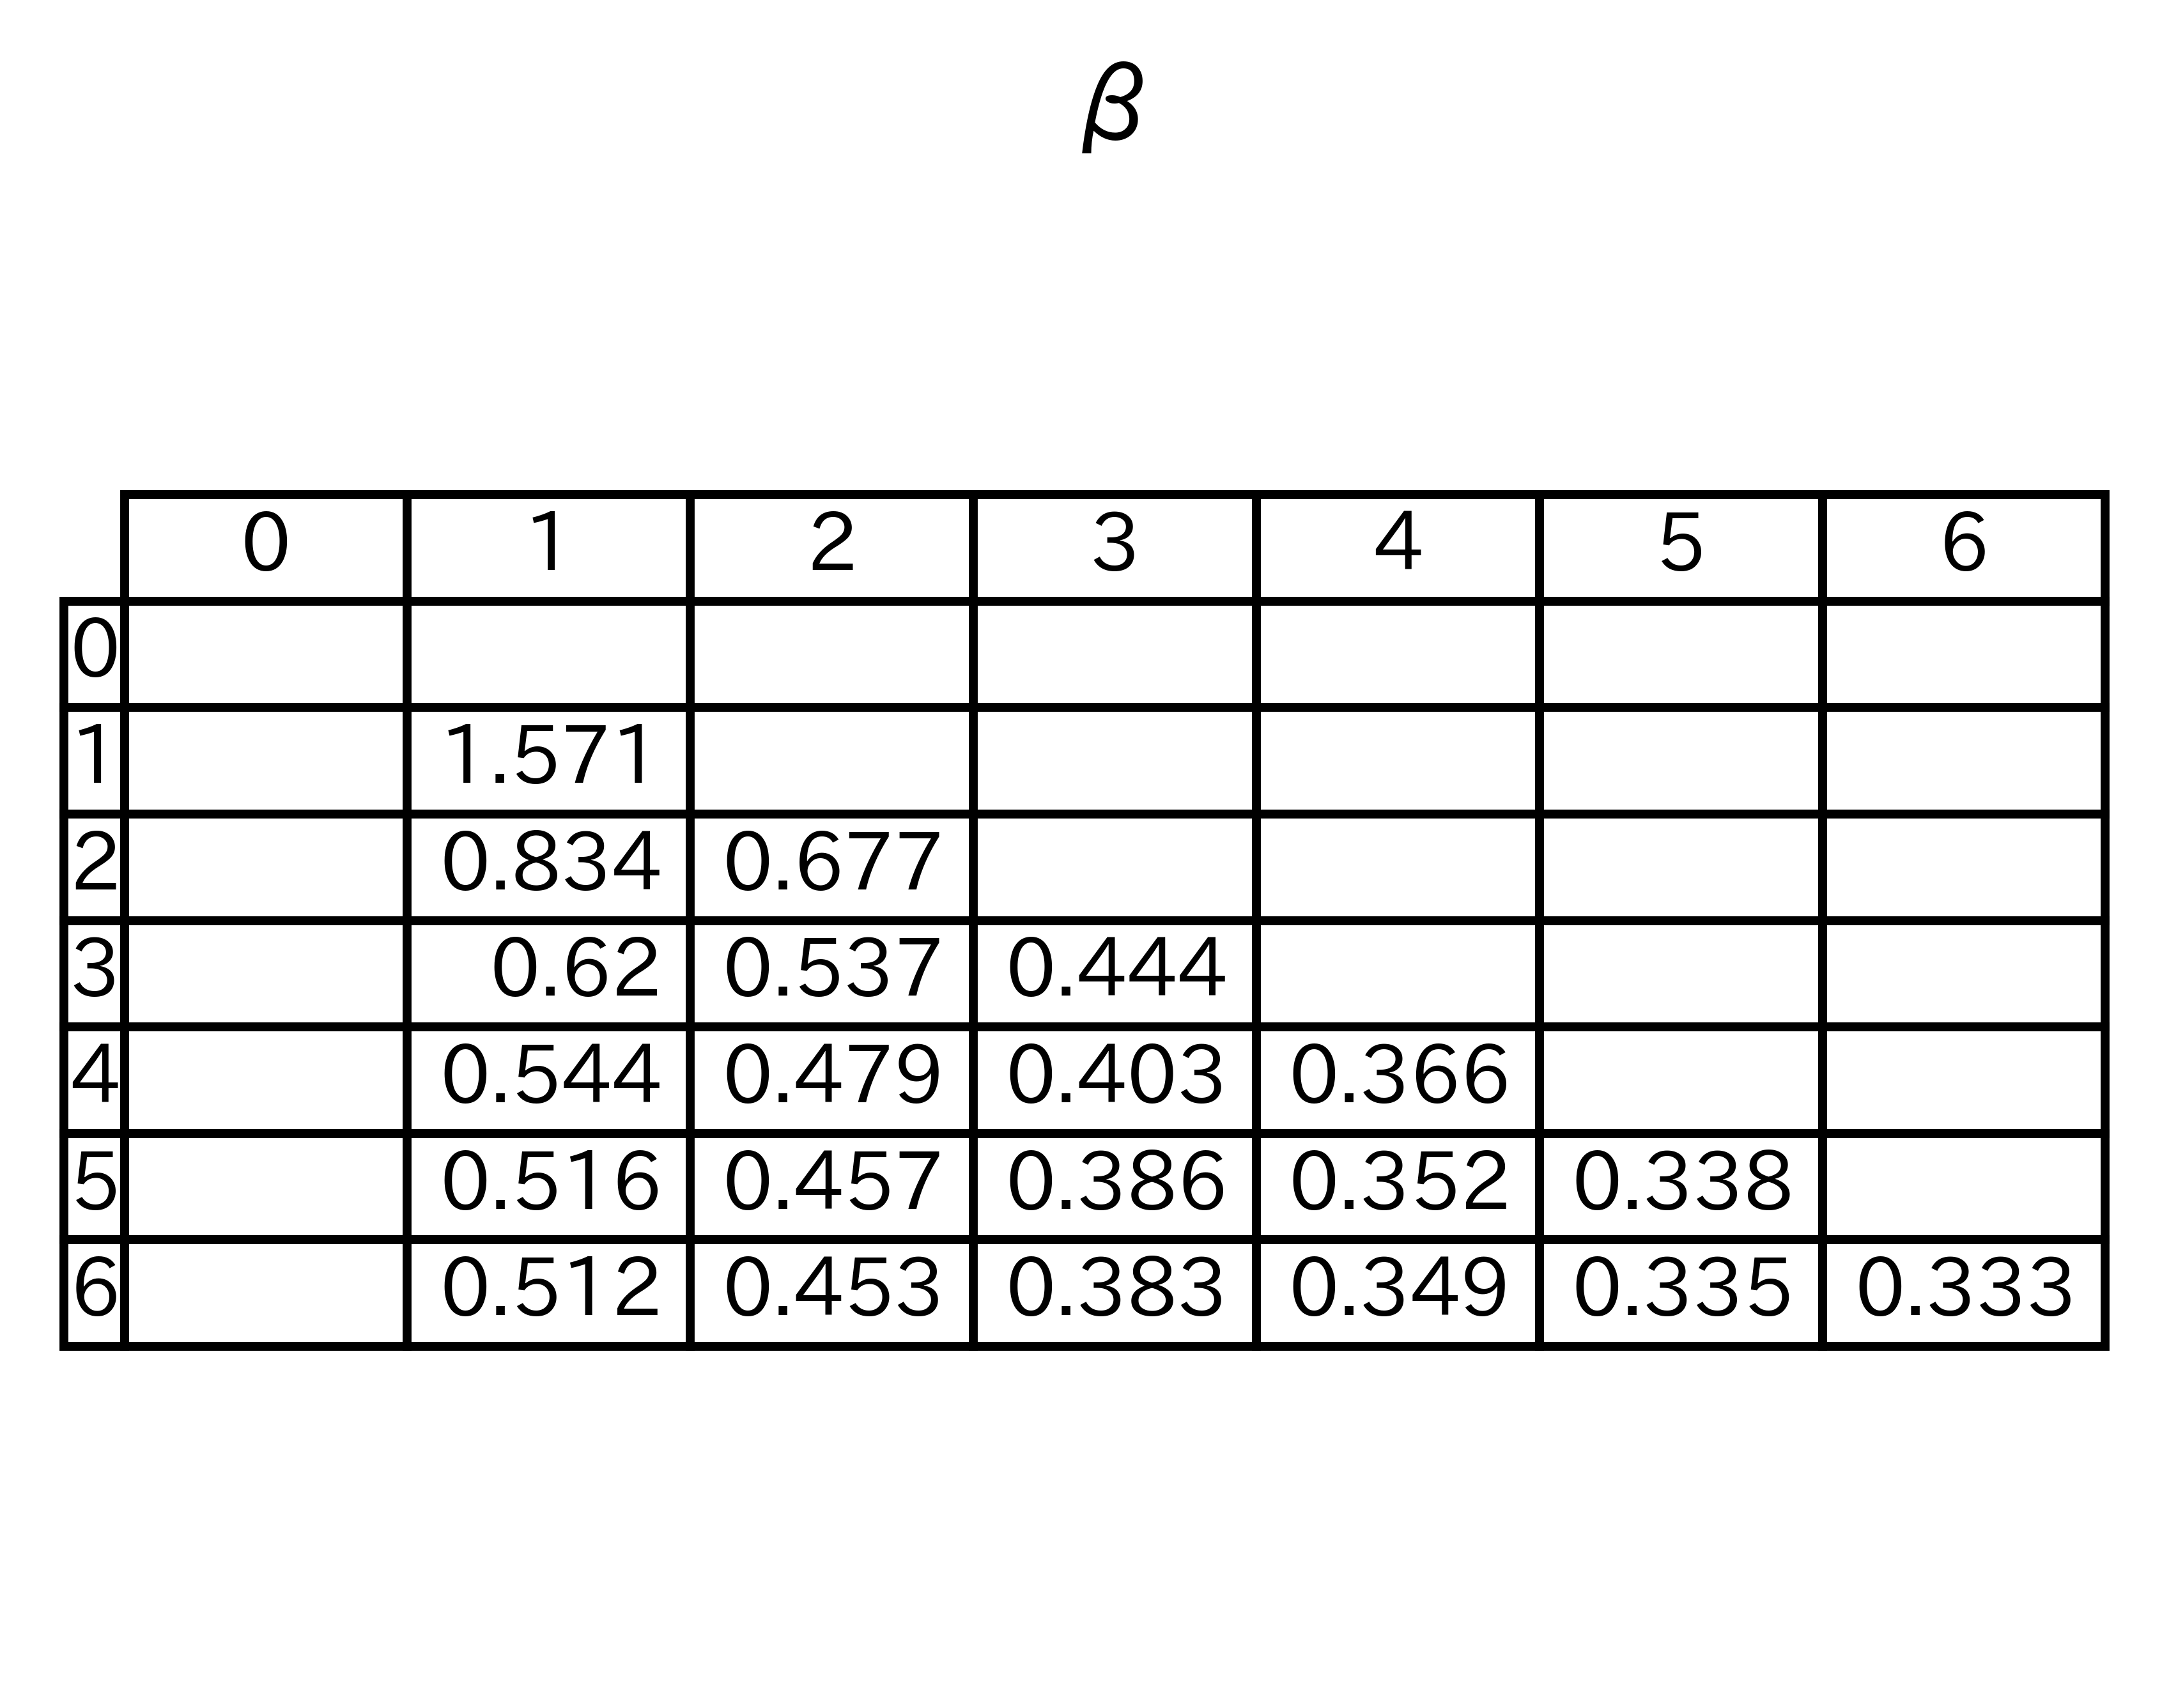

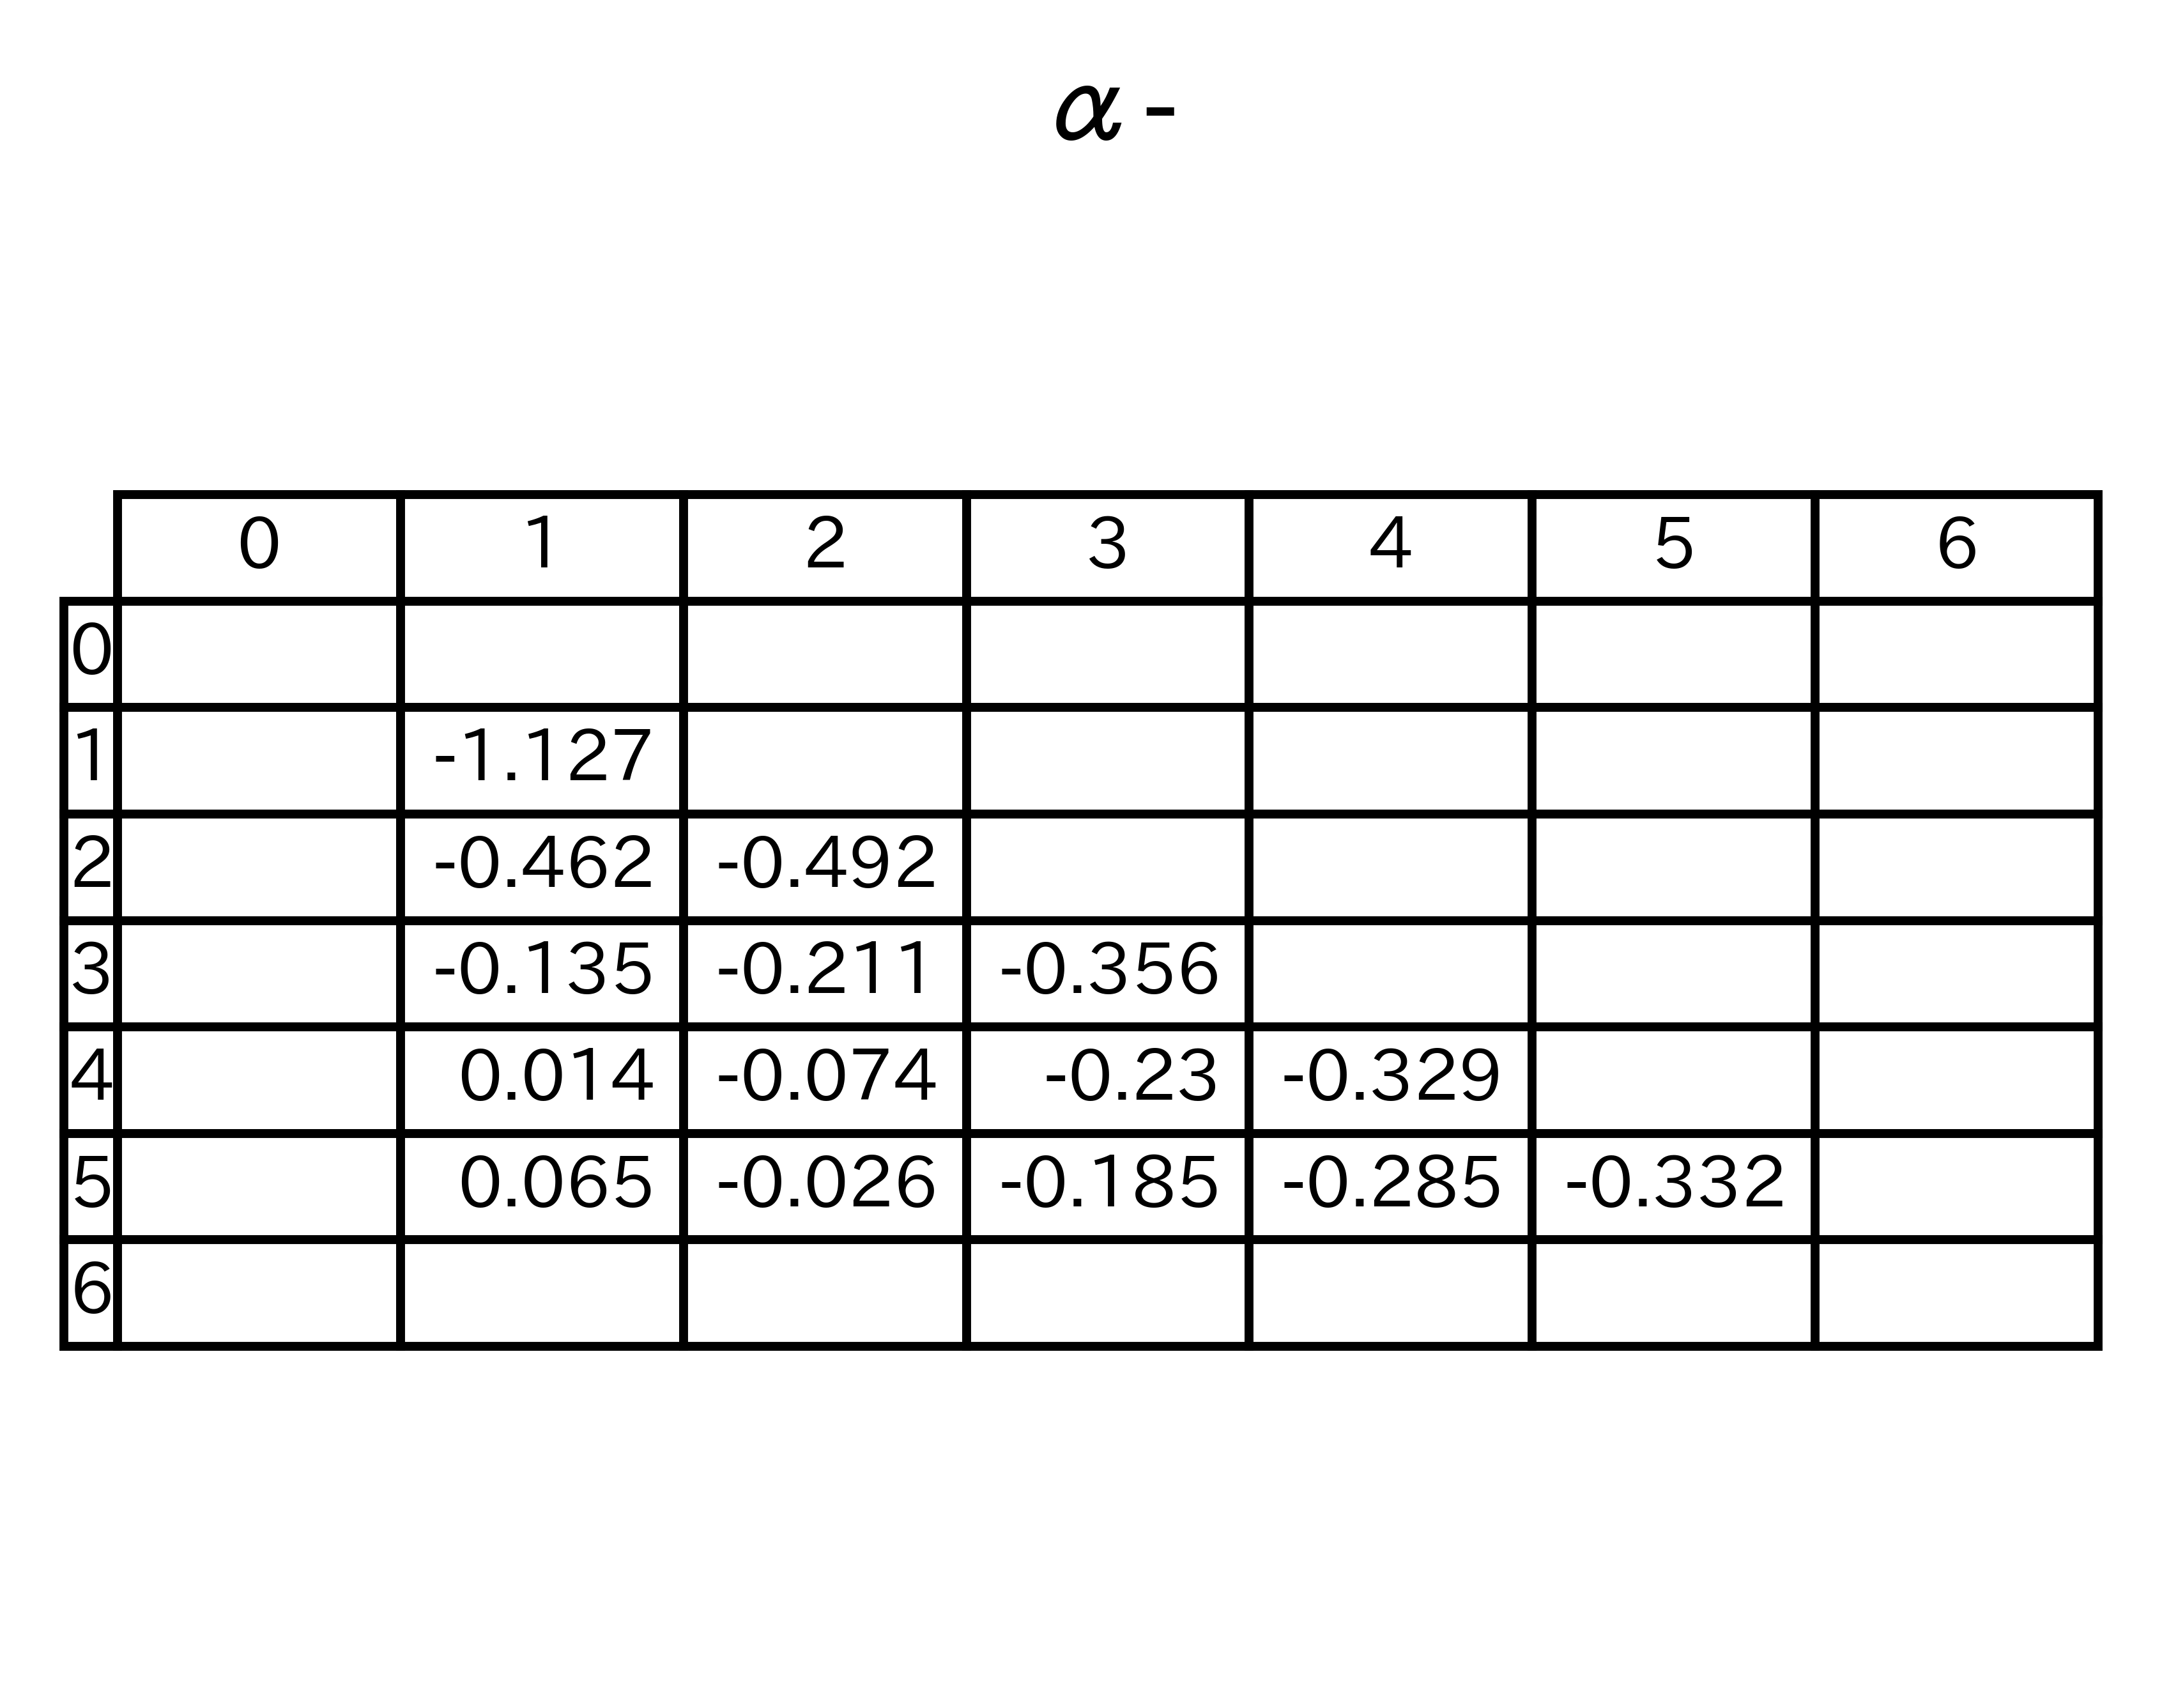

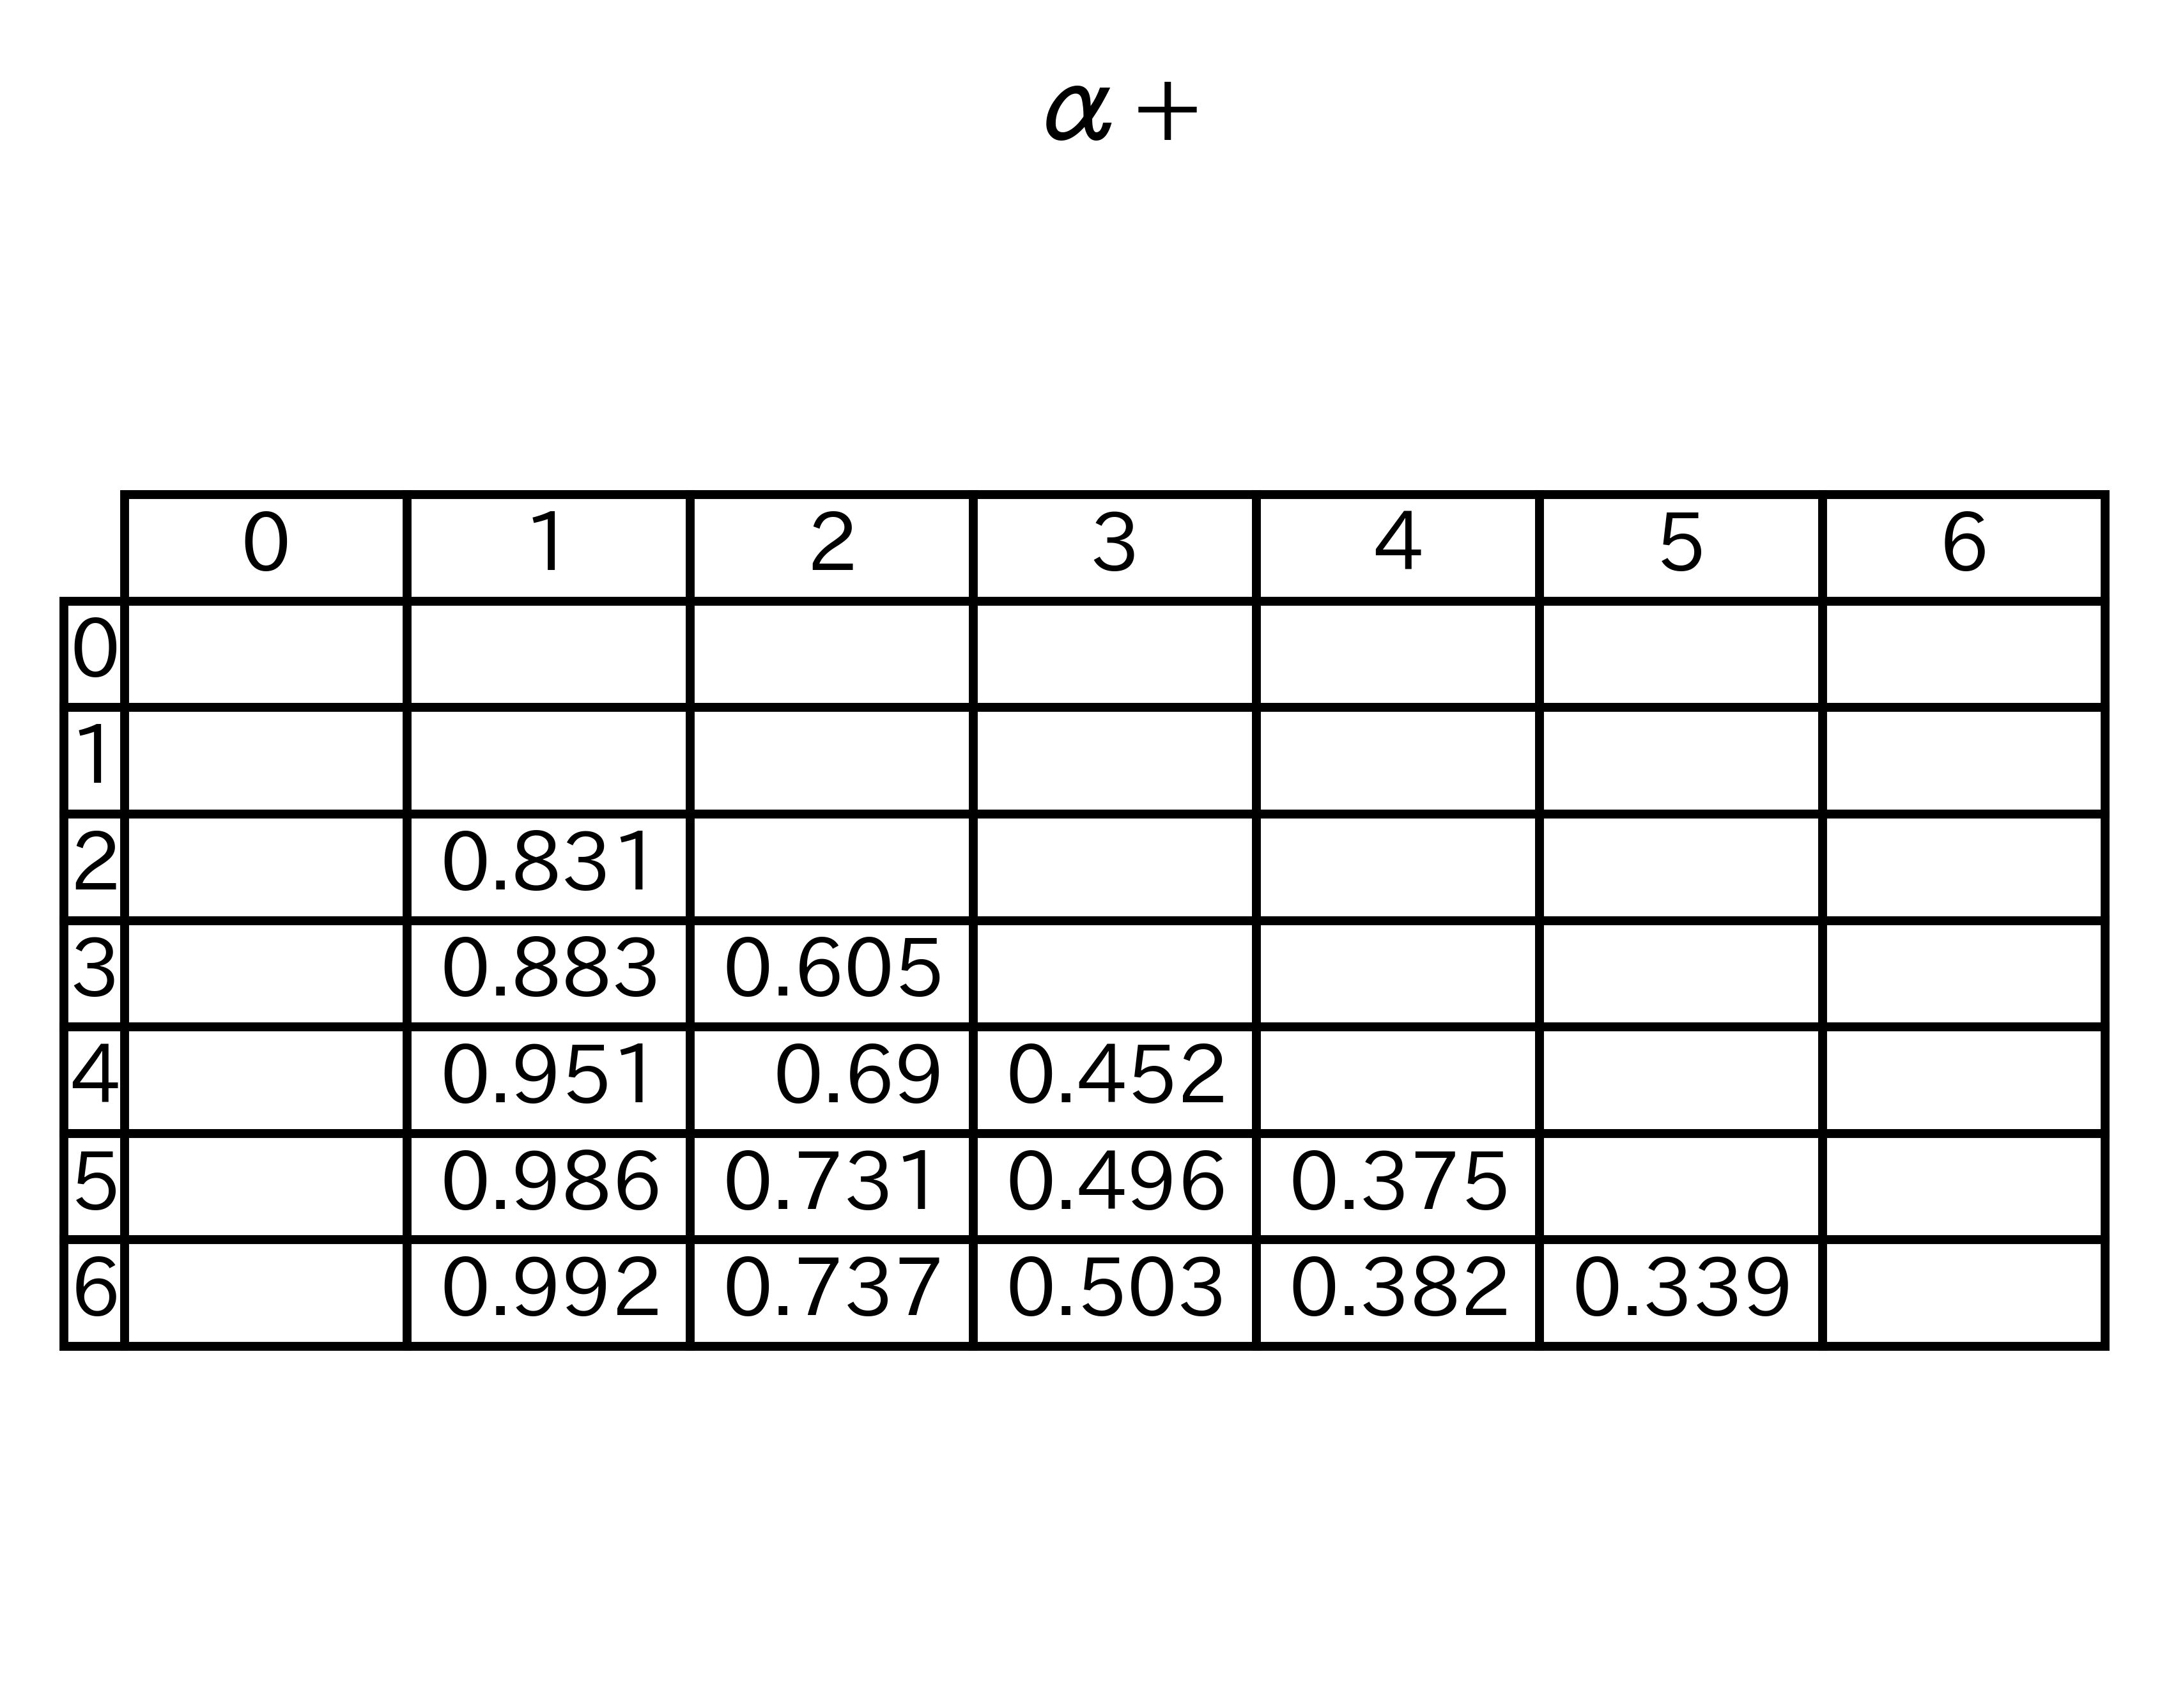

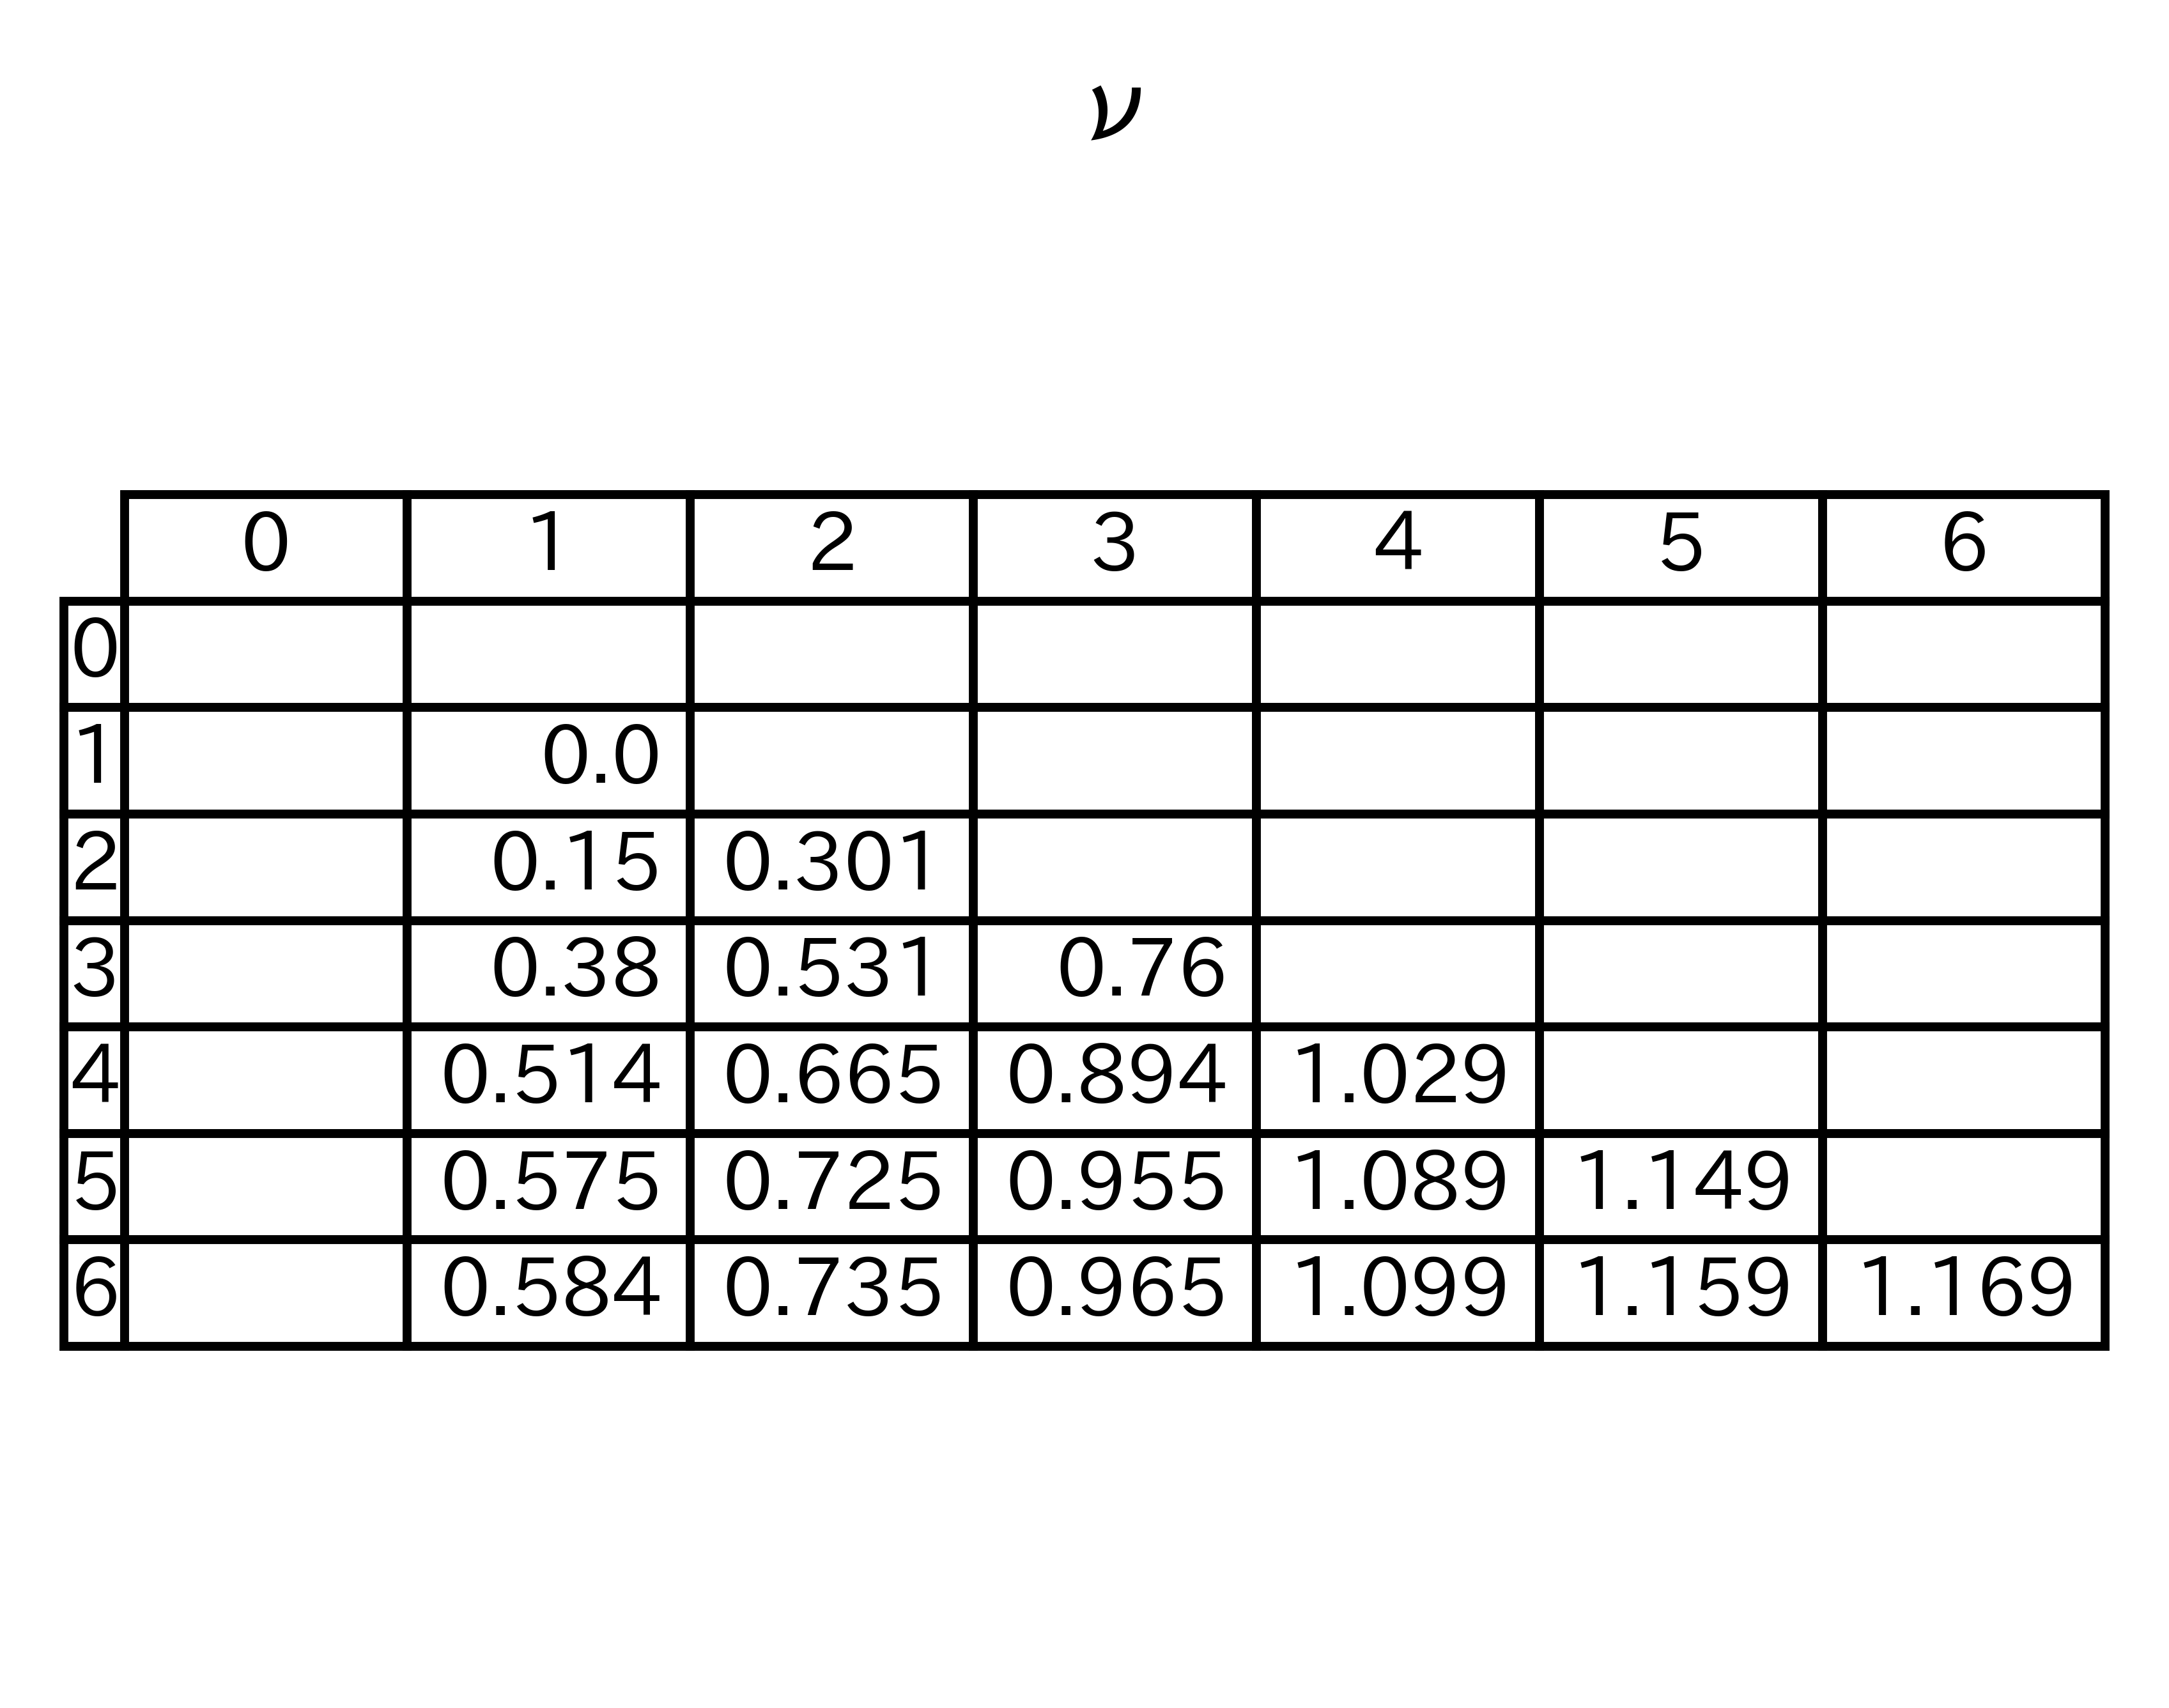

In [ ]:

#エクセルへの書き込み

excel_list = [cross_point_x, cross_point_y, M_area, theta_area, beta_area, expi_line_rad, expr_line_rad, nu_area]
excel_name_list = ["x coordinate", "y coordinate", "mach number", "theta", "beta", "alfa-", "alfa+", "nu"]
excel_name_list = ["交点x座標", "交点y座標", "マッハ数", "θ", "β", "α-", "α+", "ν"]

with pd.ExcelWriter("圧縮12.xlsx") as writer:
    for v,name in zip(excel_list, excel_name_list):
        df = pd.DataFrame(v)
        df = df.replace('nan',np.nan)
        df = df.round(3)
        df.fillna('')
        #print(df)
        df.to_excel(writer, sheet_name=name, index=True, header=True)



#表の画像化

for v,name in zip(excel_list, excel_name_list):
    #ここめちゃくちゃ大変
    df = pd.DataFrame(v)
    df = df.replace('nan',np.nan)
    df = df.round(3)
    df = df.replace(np.nan,"")


    fig, ax = plt.subplots(figsize=(4,3), dpi=1000)
    #fig, ax = plt.subplots()
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(cellText=df.values,
             colLabels=df.columns,
             rowLabels = df.index,
             loc='center',
             #bbox=[0,0,1,1]
             )
    table.set_fontsize(14)
    ax.set_title(name)
    
    plt.show()
    #plt.savefig('table.png')


